Pozn.: zde se nacházejí importy potřebné pro to, aby po restartu kernelu běžela libovolná buňka. V rámci výkladu jsou při setkání se s určitou třídou či funkcí importy samozřejmě uvedeny.

In [2]:
import os
import dotenv
import openai
import langchain

from langchain.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.llms import OpenAI

from langchain.chains import LLMChain
from langchain.chains import SimpleSequentialChain
from langchain.chains import SequentialChain
from langchain.chains import TransformChain

from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser

from langchain.chains import ConversationChain
from langchain.prompts import MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate

from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationBufferWindowMemory 
from langchain.memory import ConversationTokenBufferMemory 
from langchain.memory import ConversationSummaryMemory 
from langchain.memory import ConversationEntityMemory 
from langchain.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE

from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.document_loaders import UnstructuredHTMLLoader
from langchain.document_loaders import BSHTMLLoader
from langchain.document_loaders import WebBaseLoader
from langchain.document_loaders import UnstructuredURLLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import Language
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_core.documents.base import Document

from langchain.chains import RetrievalQA
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

from langchain.schema.output_parser import StrOutputParser

from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser



dotenv.load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]

llm_model_name = "gpt-4o-mini" #jmeno modelu, ktery se bude pouzivat napric celym notebookem.

USER_AGENT environment variable not set, consider setting it to identify your requests.


V době psaní těchto řádků je to už několik měsíců, co vzalo ChatGPT svět útokem. Člověk se tak mohl pravidelně i ve sdělovacích prostředcích setkávat s více či méně relevantními články o AI. Tento spisek nemá ambice kráčet jim po boku - absolutně netuším, zda AI (z nějakého důvodu ztotožněná s generativními modely - např. s "doplňovači" textu ala GPT) začne nahrazovat zaměstnance, zda nás vyhubí anebo zda život půjde dál ve starých kolejích. Namísto toho bych tu chtěl ukázat, jak pracovat s modely od OpenAI a to sice jak napřímo, tak skrze framework Langchain.  
Na tomto místě musím doporučit [langchainové kurzy](https://www.deeplearning.ai/short-courses/), které jsou dostupné na deeplearning.ai a ze kterých jsem při tvoření tohoto textu vycházel.

# Obsah
- [OpenAI](#OpenAI)
  - [Tokeny](#Tokeny)
  - [API klíč](#API-klíč)
  - [Jednoduchý příklad](#Jednoduchý-příklad)
  - [Chatbot](#Chatbot)
- [Langchain](#Langchain)
  - [Šablony promptů](#Šablony-promptů)
  - [Chains](#Chains)
    - [LLMChain](#LLMChain)
    - [Sekvenční chainy](#Sekvenční-chainy)
    - [RouterChain](#RouterChain)
    - [Transformation chain](#Transformation-chain)
  - [Paměť](#Paměť)
    - [ConversationBufferMemory](#ConversationBufferMemory)
    - [ConversationBufferWindowMemory](#ConversationBufferWindowMemory)
    - [ConversationTokenBufferMemory](#ConversationTokenBufferMemory)
    - [ConversationSummaryMemory](#ConversationSummaryMemory)
    - [ConversationEntityMemory](#ConversationEntityMemory)
  - [Q&A nad dokumenty](#Q&A-nad-dokumenty)
    - [Načtení dokunetů](#Načtení-dokumentů)
      - [Načtení pdfka](#Načtení-pdfka)
      - [Načtení html souboru](#Načtení-html-souboru)
      - [Načtení webové stránky](#Načtení-webové-stránky)
    - [Splittery](#Splittery)
    - [Embeddings, vectorstore](#Embeddings,-vectorstore)
    - [Similarity search](#Similarity-search)
    - [Question answering](#Question-answering)
    - [Automatické používání metadat](#Automatické-používání-metadat)
    - [Prefix před fragmenty](#Prefix-před-fragmenty)
  - [Kompletní ukázky](#Kompletní-ukázky)
    - [Obyčejný chatbot](#Obyčejný-chatbot)
    - [Q&A chatbot](#Q&A-chatbot)

# OpenAI
### Tokeny
Pro použití OpenAI člověk napřed musí sebe i svou kartu registrovat [zde](https://platform.openai.com/). Na stránkách je poté třeba nechat si vygenerovat API klíč, s jehož pomocí při RESTovém volání OpenAI pozná, co má komu vlastně naúčtovat. Ceník nalezneme [tady](https://openai.com/pricing). Je vhodné zdůraznit, že narozdíl od dejme tomu Midjourney si člověk nekupuje měsíční předplatné, nýbrž platí za míru používání modelů. Přesněji platí za počet modelem zpracovaných tokenů. Do toho se počítají jak tokeny do modelu vstupující, tak tokeny modelem produkované. A co že je vlastně onen token? Jedná se o skupinu písmen, která tvoří slovo anebo jeho část. V angličtině v průměru vychází 1 token na 0,75 slova, v jiných jazycích je poměr horší. Pro získání reálné představy doporučuji podívat se [sem](https://platform.openai.com/tokenizer). Krom očividného omezení peněženkou je součet vstupních a výstupních tokenů (a tak i délka textu) omezen pamětí modelu (kontextem z pricing stránky) - například pro 4K GPT-3.5 model není možné mít text (otázku a odpověď) delší než 4000 tokenů - nadbytečné tokeny budou oříznuty, resp. vůbec nevzniknou. O tom se člověk může předvědčit v "klasickém" webovém GUI rozhraní ChatGPT. Model sám o sobě si nepamatuje, co se dělo v předchozím hovoru. Proto se mu musí celá historie konverzace při každé interakci posílat nanovo. Po čase je historie příliš dlouhá a tak jsou staré tokeny zahozeny a model tudíž začne zapomínat začátky konverzací.

### API klíč
První tutoriálový příklad na [stránkách openai balíčku](https://pypi.org/project/openai/) začíná s 
```python
import openai
openai.api_key = "sk-..."  # supply your API key however you choose
```
Jeho problém tkví ve skutečnosti, že je API klíč umístěn uprostřed kódu. Když si člověk nedá pozor a kód někam pošle (třeba na GitHub), může se jeho jménem (a jeho peněženkou) GPT modelů dotazovat celý internet. Proto bude lepší používat [python-dotenv](https://pypi.org/project/python-dotenv/) balíček. S jeho pomocí Python načte klíč z .env souboru a nastaví ho jako proměnnou prostředí. Jak to konkrétně provedeme? Nejprve si ve stejném adresáři, ve kterém se nalézá notebook (ipynb soubor), vytvoříme .env soubor (opravdu se takto jmenuje, tj. v názvu je jen přípona) a vložíme do něj
```
OPENAI_API_KEY=nazdar1234
```
Poté naimportujeme *dotenv* a provoláme funkci *load_dotenv*.

In [4]:
import dotenv
dotenv.load_dotenv();

Že se proměnná prostředí načetla ověříme s pomocí balíčku *os*:

In [ ]:
# import os
# os.environ["OPENAI_API_KEY"]

Pokud pracujeme s Azure OpenAI, je třeba inicializovat ještě několik dalších proměnných prostředí. Na těch už nic moc tajného není, tudíž mohou být volně v kódu. Vypadají nějak takto:
```python
openai.api_type = "azure"
openai.api_version = "2023-03-15-preview"
openai.api_base = "http://testingazureopenai.openai.azure.com"
```
Api type bude asi vždy stejné, api version se bude s časem měnit a nakonec api base závisí na jméně openai resourcu. Tyto parametry se dají nejsnadněji zjistit, když v AzureAI studiu vlezeme do "Chat Playground" a v sekci "Chat Session" klepneme na "View Code". 

### Jednoduchý příklad
Nyní ale přikročme k prvnímu chatovacímu příkladu. Napřed si načteme potřebné balíčky a API klíč. Ten je potřeba vložit do *OpenAI* objektu, konkrétně do parametru *api_key*.

In [6]:
import os
from openai import OpenAI
import dotenv

dotenv.load_dotenv()
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

Následně si vytvoříme objekt reprezentující chat a to s pomocí [*chat.completions.create*](https://platform.openai.com/docs/api-reference/chat/create). Tomu podhodíme jednak model, který chceme používat (parametr *model*), jednak dosavadní historii konverzace (parametr *messages*). Ta má podobu listu jsonů obsahujících jednak informaci o mluvčím (klíč "role" s hodnotami "user" či "assistant"), jednak samotnou promluvu (klíč "content").

In [6]:
completion = client.chat.completions.create(
    messages=[
        {"role": "user", "content": "Ahoj."}
    ],
    model=llm_model_name,
)

Výstupem je následující věc. Všimněte si, že na konci dostáváme i informaci o počtu použitých tokenů.

In [8]:
completion

ChatCompletion(id='chatcmpl-AAb2rpyA8AVOoTmkJOu0qeqg1KPdX', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Ahoj! Jak ti mohu pomoci?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1727089045, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=11, prompt_tokens=11, total_tokens=22, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))

Pokud chceme ale jen odpověď chatbota, použijeme

In [9]:
completion.choices[0].message.content

'Ahoj! Jak ti mohu pomoci?'

Do *create* metody lze vložit další parametry. Například *temperature*, která s rostoucí hodnotou vede k chaotičtějším/kreativnějším odpovědím. Podle dokumentace je minimum 0, maximum 2 a default 1. Obecně ale hodnoty větší než 1 vedou obvykle k nesmyslné změti písmen.

In [10]:
completion = client.chat.completions.create(
  model=llm_model_name,
  messages=[
    {"role": "user", "content": "Ahoj."}
  ],
  temperature=2
)

completion.choices[0].message.content

'Ahoj! Jak ti mohu hoje pomoci?'

Do *messages* lze vložit i tzv. systémový prompt, který chatbotu říká,v jaké roli má vlastně vystupovat. Takováto věc se označuje klíčem "system".

In [17]:
completion = client.chat.completions.create(
  model=llm_model_name,
  messages=[
    {"role": "system", "content": "Jsi veverka milující oříšky. Odpovídáš maximálně ve dvou větách."},
    {"role": "user", "content": "Co bych si měl dát ke svačině?"}
  ],
  temperature=0.7
)

print(completion.choices[0].message.content)

Určitě zkus oříšky! Jsou chutné a plné energie!


Pozn.: výše uvedené informace platí pro verzi balíčku openai větší nebo rovnou 1.0.0 ze září 2023. Pokud musíte pracovat s verzí starší, vypadá kód nějak takto:

In [ ]:
import os
import openai
import dotenv

dotenv.load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]

completion = openai.ChatCompletion.create(
  model=llm_model_name,
  messages=[
    {"role": "user", "content": "Ahoj."}
  ]
)

Pokud pracujeme s Azure OpenAI, musíme napsat něco v následujícím duchu:
```python
from openai import AzureOpenAI

client = AzureOpenAI(
    api_version=openai.api_version,
    azure_endpoint=openai.api_base,
    api_key=openai.api_key
)

completion = client.chat.completions.create(
    model="jmeno_deploymentu",
    messages=[
        {"role": "user", "content": "Ahoj."}
    ]
)
```

### Chatbot
Bohužel kód jak ho tady máme jako chatbot nefunguje - nijak se tu neukládá historie konverzací a pokaždé tak začínáme nanovo. V openai balíčku se žádná příhodná funkce ani třída nenalézá a tak si celou (byť v tomto případě ultra krátkou) logiku musíme napsat sami.

In [7]:
chat_history = [
    {"role": "system", "content": "Jsi veverka milující oříšky. Odpovídáš maximálně ve dvou větách."}
  ]

print("Pro ukončení konverzace napište 'exit'")

while True:
    user_message = input("Uživatel: ")
    if user_message == "exit":
        break
    chat_history.append(
        {"role": "user", "content": user_message}
    )
    conversation = client.chat.completions.create(
        model=llm_model_name,
        messages=chat_history,
        temperature=0.7
    )
    chatbot_answer = conversation.choices[0].message.content
    chat_history.append(
        {"role": "assistant", "content": chatbot_answer}
    )
    print(f"Chatbot: {chatbot_answer}")

Pro ukončení konverzace napište 'exit'
Chatbot: Ahoj! Mám se skvěle, právě jsem našla spoustu oříšků!


# Promty
Protoze prace jde usnadnit, tak existuji promty jakozto promenne, ktere se davaji do funkce:

In [10]:
def get_completion(prompt, client, model=llm_model_name):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    return response.choices[0].message.content


In [12]:
get_completion("What is 1+1?", client)

'1 + 1 equals 2.'

In [16]:
customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse,\
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

In [17]:
style = """American English \
in a calm and respectful tone
"""

In [18]:
prompt = f"""Translate the text \
that is delimited by triple backticks 
into a style that is {style}.
text: ```{customer_email}```
"""

print(prompt)

Translate the text that is delimited by triple backticks 
into a style that is American English in a calm and respectful tone
.
text: ```
Arrr, I be fuming that me blender lid flew off and splattered me kitchen walls with smoothie! And to make matters worse,the warranty don't cover the cost of cleaning up me kitchen. I need yer help right now, matey!
```



In [19]:
response = get_completion(prompt, client)
response

'I am quite frustrated that the lid of my blender came off and splattered my kitchen walls with smoothie. To make matters worse, the warranty does not cover the cost of cleaning up my kitchen. I would really appreciate your assistance with this issue. Thank you.'

# Langchain
Sice bychom mohli pokračovat v používání čistého openai balíčku, ale museli bychom přitom programovat více, než by bylo potřeba. Existuje totiž balíček Langchain, který hromadu práce udělá za nás.  
Pozn.: I v případě Langchainu se s postupem času objevily změny. Původní kód bude dohledatelný v historii repa, které právě čtete. Krom změn kódu se objevila i potřeba nainstalovat si integrační balíček [langchain-openai](https://pypi.org/project/langchain-openai/).

### Šablony promptů

S pomocí šablon lze s minimální prací navíc přepoužívat i poměrně komplexní prompty. Pro názornost nicméně začněme něčím jednoduchým.  
Napřed si napíšeme stringový základ šablony, ve kterém vložíme dodatečné parametry do složených závorek. Vlastně to vypadá jako f-stringy, jen to f-ko na začátku chybí. Šablonu jako takovou vytvoříme s pomocí *ChatPromptTemplate.from_template*, do které jako parametr vložíme string z předchozího kroku.

In [20]:
from langchain.prompts import ChatPromptTemplate

template_text = """
V jedné větě shrň text obklopený trojicí uvozovek. Odpověď musí být napsána v {language} jazyce. 
Text: '''{text}'''
"""
prompt_template = ChatPromptTemplate.from_template(template_text)

Takto vypadá jádro "šablonového" objektu. V první části vidíme jména do šablony dosazovaných proměnných.

In [21]:
prompt_template.messages[0].prompt

PromptTemplate(input_variables=['language', 'text'], template="\nV jedné větě shrň text obklopený trojicí uvozovek. Odpověď musí být napsána v {language} jazyce. \nText: '''{text}'''\n")

In [22]:
language = "anglickém"

Jako testovací text použijeme kousek z [wiki článku o veverkách](https://cs.wikipedia.org/wiki/Veverka_obecn%C3%A1).

In [24]:
squirrel_text = """
Veverka obecná obvykle dorůstá 19 až 23 cm a dosahuje hmotnosti mezi 250 a 340 g někdy i víc. 
Huňatý ocas, který napomáhá udržovat rovnováhu při lezení a skocích na stromech a který veverka využívá 
jako „pokrývku“ těla při spánku, je 14,5 až 20 cm dlouhý.[3] Charakteristickým znakem veverky obecné jsou střapce 
chlupů na ušních boltcích směřující do špičky a viditelné především v zimním období. 
Stejně jako většina stromových veverek má i veverka obecná ostré a zakřivené drápy, které jí pomáhají při lezení po větvích stromů. 
"""

Proměnné se do šablony dostanou v rámci provolání metody *format_messages*. V ní by každé proměnné měl odpovídat jeden parametr nesoucí její jméno.

In [25]:
filled_template = prompt_template.format_messages(
    language=language,
    text=squirrel_text
)

Výsledek vypadá následně:

In [26]:
filled_template

[HumanMessage(content="\nV jedné větě shrň text obklopený trojicí uvozovek. Odpověď musí být napsána v anglickém jazyce. \nText: '''\nVeverka obecná obvykle dorůstá 19 až 23 cm a dosahuje hmotnosti mezi 250 a 340 g někdy i víc. \nHuňatý ocas, který napomáhá udržovat rovnováhu při lezení a skocích na stromech a který veverka využívá \njako „pokrývku“ těla při spánku, je 14,5 až 20 cm dlouhý.[3] Charakteristickým znakem veverky obecné jsou střapce \nchlupů na ušních boltcích směřující do špičky a viditelné především v zimním období. \nStejně jako většina stromových veverek má i veverka obecná ostré a zakřivené drápy, které jí pomáhají při lezení po větvích stromů. \n'''\n")]

Alternativni priklad s jinyma promennyma:

In [27]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

In [28]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(template_string)


In [29]:
prompt_template.messages[0].prompt

PromptTemplate(input_variables=['style', 'text'], template='Translate the text that is delimited by triple backticks into a style that is {style}. text: ```{text}```\n')

In [30]:
prompt_template.messages[0].prompt.input_variables

['style', 'text']

In [31]:
customer_style = """American English \
in a calm and respectful tone
"""

In [32]:
customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, \
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

In [33]:
customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

In [34]:
print(type(customer_messages))
print(type(customer_messages[0]))
print(customer_messages[0])

<class 'list'>
<class 'langchain_core.messages.human.HumanMessage'>
content="Translate the text that is delimited by triple backticks into a style that is American English in a calm and respectful tone\n. text: ```\nArrr, I be fuming that me blender lid flew off and splattered me kitchen walls with smoothie! And to make matters worse, the warranty don't cover the cost of cleaning up me kitchen. I need yer help right now, matey!\n```\n"


Nyní musíme Langchainu říct, s jakým jazykovým modelem má pracovat. Pro podporované modely přitom existují separátní třídy. Seznam nalezneme [zde](https://python.langchain.com/docs/integrations/llms/). Zdůrazněme, že zatímco balíček openai dokázal obhospodařit jak OpenAI modely, tak Azure OpenAI modely, zde se jedná o separátní entity. Navíc historicky byl a asi pořád je rozdíl mezi třídami OpenAI a ChatOpenAI importovanými nyní z langchain_openai.  
Jaké parametry můžeme do konstruktoru ChatOpenAI vložit? Jedná se primárně o teplotu (parametr *temperature* s defaultní hodnotou 0.7) a jméno LLM modelu (parametr *model_name* s defaultní hodnotou "gpt-3.5-turbo"). API klíč můžeme předávat parametrem *api_key* - pokud tak explicitně neuděláme, bude Langchain klíč hledat v *os.environ\["OPENAI_API_KEY"\]*.

In [41]:
from langchain_openai import ChatOpenAI
chat = ChatOpenAI(temperature=0.0, model_name=llm_model_name)

Když pak do metody *invoke* našeho chatovacího modelu vložíme jako parametr šablonu a výsledku se zeptáme na atribut *content*, získáme odpověď. Vidíme, že anglický jazyk sice model pochopil, ale shrnutí zabralo více než požadovanou jednu větu. no, shrnutí - text vypadá spíš jako překlad...

In [42]:
summary_response = chat.invoke(filled_template)
print(summary_response.content)

The common squirrel typically measures 19 to 23 cm in length, weighs between 250 and 340 g, has a bushy tail for balance and warmth, and is characterized by tufted ear hair and sharp, curved claws for climbing.


Jeste zkusime, co to udela, kdyz to zavolame na ten druhy priklad:

In [44]:
# Call the LLM to translate to the style of the customer message
customer_response = chat.invoke(customer_messages)

In [45]:
print(customer_response.content)

I’m quite frustrated that the lid of my blender came off and splattered smoothie all over my kitchen walls. To make matters worse, the warranty doesn’t cover the cost of cleaning up my kitchen. I would really appreciate your assistance with this issue. Thank you!


Dalsi priklad:

In [46]:
service_reply = """Hey there customer, \
the warranty does not cover \
cleaning expenses for your kitchen \
because it's your fault that \
you misused your blender \
by forgetting to put the lid on before \
starting the blender. \
Tough luck! See ya!
"""

In [47]:
service_style_pirate = """\
a polite tone \
that speaks in English Pirate\
"""

In [49]:
service_messages = prompt_template.format_messages(
    style=service_style_pirate,
    text=service_reply)

print(service_messages[0].content)

Translate the text that is delimited by triple backticks into a style that is a polite tone that speaks in English Pirate. text: ```Hey there customer, the warranty does not cover cleaning expenses for your kitchen because it's your fault that you misused your blender by forgetting to put the lid on before starting the blender. Tough luck! See ya!
```



In [50]:
service_response = chat.invoke(service_messages)
print(service_response.content)

Ahoy, esteemed customer! I be regretful to inform ye that the warranty be not coverin' the expenses for cleanin' yer galley, as it appears ye may have misused yer blender by forgettin' to secure the lid afore settin' it to whirl. Aye, 'tis a bit of tough luck, indeed! Fair winds to ye, and may we cross paths again!


Člověka by napadlo, že se text bez ztráty informací do jedné věty možná shrnout nedá a nízká teplota zabraňuje kreativnější práci s informacemi.

In [51]:
chat = ChatOpenAI(
    temperature=0.7, 
    model_name=llm_model_name
)
summary_response = chat.invoke(filled_template)
print(summary_response.content)

The Eurasian squirrel typically measures 19 to 23 cm in length and weighs between 250 and 340 g, featuring a bushy tail for balance and warmth, ear tufts, and sharp, curved claws for climbing.


Nicméně možná si model zkrátka co se instrukcí týče jenom nerozumí s češtinou tak dobře jako s angličtinou.

In [52]:
template_text = """
Summarize the text surrounded by three quotation marks in one sentence. The answer must be written in {language} language. 
Text: '''{text}'''
"""
prompt_template = ChatPromptTemplate.from_template(template_text)
language = "czech"

filled_template = prompt_template.format_messages(
    language=language,
    text=squirrel_text
)

chat = ChatOpenAI(
    temperature=0.0, 
    model_name=llm_model_name
)
summary_response = chat.invoke(filled_template)
print(summary_response.content)

Veverka obecná dorůstá délky 19 až 23 cm, váží mezi 250 a 340 g, má huňatý ocas dlouhý 14,5 až 20 cm, charakteristické střapce na uších a ostré drápy pro lezení po stromech.


Možná se nám někdy stane, že bude odpověď useknutá. To nejspíš bude dáno skutečností, že defaultní hodnota parametru *max_tokens* pro *ChatOpenAI*, která má velikost 256, na celou odpověď zkrátka nestačí. Pokud nechceme být omezováni (resp. pokud chceme být omezeni jen maximální velikostí kontextového okna), vložíme do parametru -1.

In [53]:
template_text = """
Summarize the text surrounded by three quotation marks in one sentence. The answer must be written in {language} language. 
Text: '''{text}'''
"""
prompt_template = ChatPromptTemplate.from_template(template_text)
language = "czech"

filled_template = prompt_template.format_messages(
    language=language,
    text=squirrel_text
)

chat = ChatOpenAI(
    temperature=0.0, 
    model_name=llm_model_name,
    max_tokens=22
)
summary_response = chat.invoke(filled_template)
print(summary_response.content)

Veverka obecná dorůstá délky 19 až 23 cm, váží mezi 250


## Output Parser

Zkusme nyní lehce komplikovanější šablonu, která se bude koukat na [popis hry Na křídlech](https://www.tlamagames.com/deskove-hry/wingspan/).

In [54]:
wingspan_text = """
Wingspan je kompetitivní středně těžká hra využívající karty a engine building mechanismus.

Stáváte se nadšenými ornitology a sběrateli a snažíte se objevit a přilákat ty nejzajímavější ptáky da Vaší sítě rezervací. Každý pták posiluje řetěz kombinací pro daný habitat (akci). Tyto habitaty jsou zaměřeny na několik klíčových oblastí rozvoje:

    Dostat žetony jídla výběrem kostky z krmítka (dice tower)
    Kladení vajec s využitím miniaturních vajec v různých barvách
    Dobrání ze stovek unikátních karet ptáků a zahrání těchto karet

Vítězem je ten hráč, který má po 4 kolech nejvíce bodů.

Pokud máte rádi hry jako Terraforming Mars a Gizmos, tak by tahle hra měla zalétnout na Váš stůl.

Hra je určena pro 1-5 hráčů od 14 let.

Pravidla i herní materiál je v angličtině.
"""

template_text = """
From text surrounded by by three quotation marks extract following information.

1) Minimal age
2) Number of players
3) Victory condition

The answer must be written in {language} language in {format} format. 

Text: '''{text}'''
"""

prompt_template = ChatPromptTemplate.from_template(template_text)
language = "czech"
format = "json"

filled_template = prompt_template.format_messages(
    language=language,
    format=format,
    text=wingspan_text
)

chat = ChatOpenAI(
    temperature=0.0, 
    model_name=llm_model_name
)
summary_response = chat.invoke(filled_template)
print(summary_response.content)

```json
{
  "minimal_age": 14,
  "number_of_players": "1-5",
  "victory_condition": "Hráč s nejvíce body po 4 kolech"
}
```


In [55]:
prompt_template = ChatPromptTemplate.from_template(template_text)
language = "english"
format = "plain text"

filled_template = prompt_template.format_messages(
    language=language,
    format=format,
    text=wingspan_text
)

chat = ChatOpenAI(
    temperature=0.0, 
    model_name=llm_model_name
)
summary_response = chat.invoke(filled_template)
print(summary_response.content)

1) Minimal age: 14  
2) Number of players: 1-5  
3) Victory condition: The player with the most points after 4 rounds wins.


V případě práce s Azure OpenAI budeme namísto *ChatOpenAI* používat *AzureChatOpenAI*. Rozdíl je i v parametrech - nebudeme specifikovat *model_name*, nýbrž *deployment_name*. V Azuru se totiž vytváří svého druhu instance modelů mimo (obvykle) v GUI, přičemž jsou pojmenovány právě jako deploymenty.  Vytvořené deploymenty člověk nalezne v Azure AI studiu v sekci "deployments" (do konstruktoru dáváme název z prvního sloupce tabulky).

```python
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "api_klíč"
os.environ["AZURE_OPENAI_ENDPOINT"] = "endpoint ve formátu ala http://testingazureopenai.openai.azure.com"
chat = AzureChatOpenAI(deployment_name="jmeno_deploymentu", temperature=0)
```

Jiny priklad, jak definovat vystup z LLM modelu:

In [56]:
{
  "gift": False,
  "delivery_days": 5,
  "price_value": "pretty affordable!"
}

{'gift': False, 'delivery_days': 5, 'price_value': 'pretty affordable!'}

In [57]:
customer_review = """\
This leaf blower is pretty amazing.  It has four settings:\
candle blower, gentle breeze, windy city, and tornado. \
It arrived in two days, just in time for my wife's \
anniversary present. \
I think my wife liked it so much she was speechless. \
So far I've been the only one using it, and I've been \
using it every other morning to clear the leaves on our lawn. \
It's slightly more expensive than the other leaf blowers \
out there, but I think it's worth it for the extra features.
"""

review_template = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product \
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

Format the output as JSON with the following keys:
gift
delivery_days
price_value

text: {text}
"""

In [58]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(review_template)
print(prompt_template)

input_variables=['text'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['text'], template='For the following text, extract the following information:\n\ngift: Was the item purchased as a gift for someone else? Answer True if yes, False if not or unknown.\n\ndelivery_days: How many days did it take for the product to arrive? If this information is not found, output -1.\n\nprice_value: Extract any sentences about the value or price,and output them as a comma separated Python list.\n\nFormat the output as JSON with the following keys:\ngift\ndelivery_days\nprice_value\n\ntext: {text}\n'))]


In [70]:
messages = prompt_template.format_messages(text=customer_review)
chat = ChatOpenAI(temperature=0.0, model=llm_model_name)
response = chat.invoke(messages)
print(response.content)

```json
{
  "gift": true,
  "delivery_days": 2,
  "price_value": ["It's slightly more expensive than the other leaf blowers out there", "I think it's worth it for the extra features"]
}
```


In [60]:
type(response.content)

str

In [ ]:
# You will get an error by running this line of code 
# because'gift' is not a dictionary
# 'gift' is a string
response.content.get('gift')

### Parse the LLM output string into a Python dictionary

In [62]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [63]:
gift_schema = ResponseSchema(name="gift",
                             description="Was the item purchased\
                             as a gift for someone else? \
                             Answer True if yes,\
                             False if not or unknown.")
delivery_days_schema = ResponseSchema(name="delivery_days",
                                      description="How many days\
                                      did it take for the product\
                                      to arrive? If this \
                                      information is not found,\
                                      output -1.")
price_value_schema = ResponseSchema(name="price_value",
                                    description="Extract any\
                                    sentences about the value or \
                                    price, and output them as a \
                                    comma separated Python list.")

response_schemas = [gift_schema, 
                    delivery_days_schema,
                    price_value_schema]

In [65]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [66]:
format_instructions = output_parser.get_format_instructions()

In [67]:
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"gift": string  // Was the item purchased                             as a gift for someone else?                              Answer True if yes,                             False if not or unknown.
	"delivery_days": string  // How many days                                      did it take for the product                                      to arrive? If this                                       information is not found,                                      output -1.
	"price_value": string  // Extract any                                    sentences about the value or                                     price, and output them as a                                     comma separated Python list.
}
```


In [68]:
review_template_2 = """\
For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? \
Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the product\
to arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,\
and output them as a comma separated Python list.

text: {text}

{format_instructions}
"""

prompt = ChatPromptTemplate.from_template(template=review_template_2)

messages = prompt.format_messages(text=customer_review, 
                                format_instructions=format_instructions)

In [69]:
print(messages[0].content)

For the following text, extract the following information:

gift: Was the item purchased as a gift for someone else? Answer True if yes, False if not or unknown.

delivery_days: How many days did it take for the productto arrive? If this information is not found, output -1.

price_value: Extract any sentences about the value or price,and output them as a comma separated Python list.

text: This leaf blower is pretty amazing.  It has four settings:candle blower, gentle breeze, windy city, and tornado. It arrived in two days, just in time for my wife's anniversary present. I think my wife liked it so much she was speechless. So far I've been the only one using it, and I've been using it every other morning to clear the leaves on our lawn. It's slightly more expensive than the other leaf blowers out there, but I think it's worth it for the extra features.


The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```

In [71]:
response = chat.invoke(messages)

In [72]:
print(response.content)

```json
{
  "gift": true,
  "delivery_days": 2,
  "price_value": ["It's slightly more expensive than the other leaf blowers out there", "I think it's worth it for the extra features"]
}
```


In [73]:
output_dict = output_parser.parse(response.content)

In [74]:
output_dict

{'gift': True,
 'delivery_days': 2,
 'price_value': ["It's slightly more expensive than the other leaf blowers out there",
  "I think it's worth it for the extra features"]}

In [75]:
type(output_dict)

dict

In [76]:
output_dict.get('delivery_days')

2

## Chains
Je načase přistoupit k věci, podle které nese Langchain své jméno - k chainům. Ty jsou [definovány](https://python.langchain.com/docs/modules/chains/) jako posloupnosti volání komponent, které mohou obsahovat další chainy. To by ve výsledku mělo vést k větší přehlednosti a snazší udržování kódu.
#### LLMChain 
Viz. [LLMChain](https://python.langchain.com/docs/modules/chains/foundational/llm_chain)
Jedná se o asi nejjednodušší chain. Člověk do něj při inicializaci nasype template a jazykový model. Při samotném použití *LLMChain* provoláme s hodnotou proměnné, která se dosadí do šablony. Výsledný textový řetězec poputuje do jazykového modelu a následně obdržíme výsledek.

In [79]:
from langchain.chains import LLMChain

llm = ChatOpenAI(temperature=0.95, model=llm_model_name)

In [80]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [81]:
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [82]:
product = "Queen Size Sheet Set"
llm_chain.invoke(product)

{'product': 'Queen Size Sheet Set',
 'text': 'Choosing a name for a company that makes queen size sheet sets can be both fun and strategic. Here are some options that convey comfort, quality, and the essence of bedding:\n\n1. **Queen’s Comfort**\n2. **Regal Rest**\n3. **Elegant Slumber**\n4. **Majestic Sheets**\n5. **Crown Comforts**\n6. **Snooze Royalty**\n7. **Sheet Serenade**\n8. **Dreamy Dimensions**\n9. **Royal Bed Linen**\n10. **Elysian Sheets**\n\nFeel free to mix and match or modify these suggestions to find a name that resonates with your brand identity!'}

Obvykle ale nechceme slovníkovou omáčku okolo, ale jen samotnou odpověď. Kdysi bylo řešením použít metodu *run*. Ta ale brzo bude odstraněna.

In [83]:
product = "Queen Size Sheet Set"
llm_chain.run(product)

/Users/michaelmateju/miniconda3/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'Choosing the best name for a company that specializes in queen-size sheet sets depends on several factors such as branding, target audience, and the overall message you want to convey. Here are some suggestions:\n\n1. **Queen Dreams**\n2. **Regal Rest**\n3. **Sheet Serenity**\n4. **Crown Comforts**\n5. **Majestic Linens**\n6. **Royal Slumber**\n7. **Queen’s Haven**\n8. **LuxiQueen Sheets**\n9. **Sleep Like Royalty**\n10. **Sovereign Sheets**\n\nThese names emphasize luxury, comfort, and the queen-size aspect, creating an appealing branding for your company. Consider your target market and brand identity when making your final choice!'

Tudíž musíme explicitně "slovníkově" zmínit, co vlastně chceme vidět.

In [84]:
product = "Queen Size Sheet Set"
llm_chain.invoke(product)["text"]

"Choosing a name for a company that specializes in queen size sheet sets should reflect comfort, quality, and perhaps even a touch of elegance. Here are some suggestions:\n\n1. **Queen's Rest**\n2. **Elegant Sheets**\n3. **SnoozeLux**\n4. **Regal Bedding**\n5. **Dreamy Queen**\n6. **Silken Slumber**\n7. **Royal Comfort Sheets**\n8. **Queenly Threads**\n9. **Sheet Serenity**\n10. **Cozy Queen**\n\nFeel free to mix and match words or modify them to better suit your brand’s identity!"

V případě, že má jít do šablony více proměnných, musíme tyto proměnné do metody *invoke* předávat jako slovník v parametru *input*.

In [92]:
prompt_template_two_var = ChatPromptTemplate.from_template(
    """
    Write the best name for {pet}. Answer should be in one sentence, in {language} language, but should contain reasoning.
    """
)

In [93]:
llm_chain_two_var = LLMChain(llm=llm, prompt=prompt_template_two_var)

In [94]:
input_vars = {"pet": "cat", "language": "german"}
llm_chain_two_var.invoke(input=input_vars)

{'pet': 'cat',
 'language': 'german',
 'text': 'Der beste Name für eine Katze ist "Schnurrli", weil er die sanfte und verspielte Natur dieser Tiere perfekt widerspiegelt.'}

Pokud člověk chce odpovědi na více separátních vstupů, není třeba popořadě manuálně provolávat model, ale lze použít metodu *apply*. Té se podhodí list slovníků s proměnnými.

Vzhledem k rychlosti vyvoje LangChainu, je nasledujici metoda uz nefunkcni. Nevim proc, proste uz nefunguje. A kdyz 
clovek googlí, tak na strance 
[dokumentace k LLMChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html#langchain.chains.llm.LLMChain) se dozvi, ze LLMChain byl taky deprecated....

In [96]:
input_list = [
    {"pet": "parrot", "language":"english"},
    {"pet": "bear", "language":"czech"},
    {"pet": "monkey", "language":"german"}
]

llm_chain_two_var.apply(input_list)

ValueError: Missing some input keys: {'language'}

#### Sekvenční chainy
Viz [Sekvenční chainy](https://python.langchain.com/docs/modules/chains/foundational/sequential_chains).
Sekvenční chainy jsou určeny pro situace, kdy výstup jednoho provolání modelu vkládáme jako vstup do provolání druhého. Existují ve dvou variantách:
- SimpleSequentialChain, který má jen jeden vstup a jeden výstup
- SequentialChain umožňující existenci více vstupů a výstupů

Pro ukázku SimpleSequentialChain si napřed vytvoříme dva LLMChainy.

In [104]:
from langchain.chains import SimpleSequentialChain

chat = ChatOpenAI(temperature=0.95, model=llm_model_name)

prompt_template_post = ChatPromptTemplate.from_template(
    "Write a LinkedIn post for company {company}."
)

post_chain = LLMChain(llm=chat, prompt=prompt_template_post)

In [105]:
prompt_template_summary = ChatPromptTemplate.from_template(
    """
    Summarize the text surrounded by three quotation marks in one sentence.
    Text: '''{text}''''
    """
)

summary_chain = LLMChain(llm=chat, prompt=prompt_template_summary)

Následně s jejich pomocí vytvoříme SimpleSequentialChain.

In [106]:
overall_chain = SimpleSequentialChain(chains=[post_chain, summary_chain], verbose=True)

Ten uvedeme do provozu provoláním metody *invoke*. Do té vložíme hodnotu, která bude dosazena do prvního LLMChainu (pořadí chainů dáno pořadím v listu vkládaného do parametru *chains*).  
Jelikož jsme *SimpleSequentialChain* vytvořili s parametrem *verbose*=True, vidíme i mezivýsledky - výstup prvního a druhého LLMChainu v modré resp. žluté barvě. A ano, jsou zde warningy. Asi se jedná o nějaké volání v pozadí; zatím jsem nepřišel na to, co mám čím nahradit.

In [107]:
post_summary = overall_chain.invoke("Hamster food Inc.")



> Entering new SimpleSequentialChain chain...
🌟 Exciting News from Hamster Food Inc.! 🌟

We’re thrilled to announce the launch of our newest product line, **Nutri-Pellets**, specially formulated to meet the unique nutritional needs of your furry friends! 🐹💚

At Hamster Food Inc., we believe that every hamster deserves a healthy and balanced diet. Our Nutri-Pellets are packed with essential vitamins and minerals, ensuring your little companions stay happy and vibrant. 

Why choose Nutri-Pellets? 

✅ High-quality ingredients  
✅ No artificial additives  
✅ Tailored nutrition for all life stages  
✅ Sustainable sourcing practices   

We are committed to supporting pet owners with high-quality products that foster the well-being of their pets. Join us on this journey to promote healthier, happier hamsters!

Check out our website to learn more about our new line and discover tips for hamster care: [INSERT LINK]

#HamsterFoodInc #PetCare #HealthyPets #NutriPellets #FurryFriends #Innovation

Výsledek jsme si uložili do proměnné *post_summary*.

In [108]:
post_summary

{'input': 'Hamster food Inc.',
 'output': 'Hamster Food Inc. has launched a new product line called Nutri-Pellets, designed to provide essential nutrition for hamsters with high-quality ingredients and no artificial additives.'}

S *verbose*=False žádné barevné výsledky neuvidíme.

In [109]:
overall_chain = SimpleSequentialChain(chains=[post_chain, summary_chain], verbose=False)
post_summary = overall_chain.invoke("Hamster food Inc.")

In [110]:
post_summary

{'input': 'Hamster food Inc.',
 'output': 'Hamster Food Inc. is excited to launch a new line of organic, nutritious food products designed to enhance the health and happiness of hamsters, while encouraging community engagement among pet lovers.'}

Nyní se podívejme na *SequentialChain*. Zde první LLMChain bude mít dva vstupy. Navíc tu v parametru *output_key* říkáme, do jak pojmenované proměnné zpracované dalšími LLMChainy se má výstup tohoto chainu uložit.

In [111]:
from langchain.chains import SequentialChain

chat = ChatOpenAI(temperature=0.95, model=llm_model_name)

prompt_template_post = ChatPromptTemplate.from_template(
    "Write a LinkedIn post for company {company} with length of {sentences_count} sentences."
)

post_chain = LLMChain(llm=chat, prompt=prompt_template_post, output_key="linkendin_post")

Dva vstupy a jeden *output_key* má i druhý *LLMChain*.

In [112]:
prompt_template_summary = ChatPromptTemplate.from_template(
    """
    Summarize the text surrounded by three quotation marks in one sentence. Use {language} language.
    Text: '''{linkendin_post}''''
    """
)

summary_chain = LLMChain(llm=chat, prompt=prompt_template_summary, output_key="summarization")

Nyní si vytvoříme *SequentialChain*. Oproti *SimpleSequentialChain* tu navíc máme parametry *input_variables* a *output_variables*. Všimněme si, že i když se proměnná *language* používá až v druhém LLMChainu, je v *input_variables*. První LLMChain ji prostě ignoruje.  
V SequentialChainu bychom mohli mít více chainů a ty by ani nemusely mít uspořádány čistě sériově. Langchain už by si je postupně pospouštěl podle potřebných input a output proměnných. Dokonce ani konec nemusí být v jednom chainu - zakončení může být více a pak je output_key každého koncového chainu umístěn do listu v *output_variables*.

In [114]:
overall_chain = SequentialChain(
    chains=[post_chain, summary_chain],
    input_variables=["company", "sentences_count", "language"],
    output_variables=["summarization"],
    verbose=True
)

Aktivovat *SequentialChain* můžeme vložením slovníku se záznamem pro každou *input_variable* do instance chainu.

In [115]:
overall_chain.invoke({"language":"czech", "sentences_count":3, "company":"Turtles speedtravel"})



> Entering new SequentialChain chain...

> Finished chain.


{'language': 'czech',
 'sentences_count': 3,
 'company': 'Turtles speedtravel',
 'summarization': 'Turtles SpeedTravel se zavazuje k vylepšení cestovních zážitků prostřednictvím inovativních a udržitelných řešení, která mění způsob, jakým objevujeme svět.'}

Všimněme si ale, že i když jsme nastavili *verbose*=True, nevidíme mezivýsledky. Netušíme tak, co se vlastně uvnitř děje. Když ale nastavíme langchain do debug modu s pomocí *langchain.debug* = True, uvidíme vše do nejmenších podrobností.

In [ ]:
import langchain
langchain.debug = True

In [ ]:
overall_chain.invoke({"language":"czech", "sentences_count":3, "company":"Turtles speedtravel"})

Jiny priklad s vice prompty a vice output_variables:

In [116]:
llm = ChatOpenAI(temperature=0.9, model=llm_model_name)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [117]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [118]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [119]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [120]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [122]:
review = "Jidlo nebylo spatny, ale zadna slava to taky nebyla"
overall_chain(review)

/Users/michaelmateju/miniconda3/envs/langchain/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new SequentialChain chain...

> Finished chain.


{'Review': 'Jidlo nebylo spatny, ale zadna slava to taky nebyla',
 'English_Review': "The food wasn't bad, but it wasn't anything special either.",
 'summary': 'The food was mediocre, neither bad nor exceptional.',
 'followup_message': 'Odpověď: Děkuji za vaši recenzi. Je škoda, že jídlo nesplnilo vaše očekávání. Rádi bychom se dozvěděli více o vašich preferencích, abychom mohli zlepšit naše menu a nabídnout našim hostům lepší zážitek. Doufáme, že nám dáte další šanci!'}

#### RouterChain
RouterChain dokáže posoudit, na který z podřízených chainů poslat uživatelský vstup. Narozdíl od sekvenčích chainů, kde je posloupnost řízena jménem proměnných (a tedy volbou programátora), v případě LLMRouterChain se o rozzařování skutečně stará jazykový model.  
Pozn.: v této podkapitole čerpám z langchainového kurzu z deeplearning.ai opravdu extenzivně - MULTI_PROMPT_ROUTER_TEMPLATE je převzat beze změn metodou ctrl+C, ctrl+V.  
Nejprve si vytvoříme základy šablon pro programování a pro vaření.

In [ ]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

it_problem_template = """You are a very smart programmer. 
You are great at answering questions about computers, programming and IT in a concise 
and easy to understand manner. 
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{input}"""

cooking_template = """Your are master chef, expert at cooking and food preparation. 
When you don't know the answer to a question you admit that you don't know.


Here is a question:
{input}
"""

prompt_infos = [
    {
        "name": "programming", 
        "description": "Good for answering questions about programming and IT", 
        "prompt_template": it_problem_template
    },
    {
        "name": "food", 
        "description": "Good for answering questions about food and cooking", 
        "prompt_template": cooking_template
    }
]

Následně dojde k vytvoření instance jazykového modelu a listu slovníku o podchainech.

In [ ]:
chat = ChatOpenAI(temperature=0)

destination_chains = {}
for one_prompt_info in prompt_infos:
    name = one_prompt_info["name"]
    prompt_template = one_prompt_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=chat, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{one_prompt_info['name']}: {one_prompt_info['description']}" for one_prompt_info in prompt_infos]
destinations_str = "\n".join(destinations)
print(destinations_str)

Vytvoříme si i defaultní podchain, kam půjdou uživatelské dotazy, které se nevejdou nikam jinam.

In [ ]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=chat, prompt=default_prompt)

Následuje extenzivní popis router šablony.

In [ ]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a 
language model select the model prompt best suited for the input. 
You will be given the names of the available prompts and a 
description of what the prompt is best suited for. 
You may also revise the original input if you think that revising
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string - name of the prompt to use or "DEFAULT"
    "next_inputs": string - a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt 
names specified below OR it can be "DEFAULT" if the input is not
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input 
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

A vytvoření samotného routeru.

In [ ]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(chat, router_prompt)

A nakonec tu máme chain, který *LLMRouterChain* obaluje a spojuje ho s podchainy.

In [ ]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

Zde máme příklad programátorského podchainu.

In [ ]:
chain.invoke("What are good packages for graphs creation in Python?")

Tady je dotaz na kuchařský podchain.

In [ ]:
chain.run("How should I prepare fried cheese?")

A nakonec defaultní podchain.

In [ ]:
chain.run("Who was Joseph II?")

#### Transformation chain
Viz [Transformation chain](https://python.langchain.com/docs/modules/chains/foundational/transformation).
Transformation chain slouží k tomu, aby se na vstupní textový řetězec použila nějaká obecná pythoní funkce. Její jméno (tj. bez parametrů a kulatých závorek) se vloží do parametru *transofrm* konstruktoru *TransformChain*.

In [123]:
from langchain.chains import TransformChain

def replace_animal(input_dict):
    orig_text = input_dict["text"]
    replaced_text = orig_text.replace("squirrel", "unicorn")
    replaced_text = replaced_text.replace("squirrels", "unicorns")
    replaced_text = replaced_text.replace("Squirrel", "Unicorn")
    replaced_text = replaced_text.replace("Squirrels", "Unicorns")
    return {"output_text": replaced_text}

transform_chain = TransformChain(
    input_variables=["text"], output_variables=["output_text"], transform=replace_animal
)

Následně se s chainy pracuje jako v předchozích příkladech.

In [124]:
template = """Find strange formulations in following text and write why are they strange:

{output_text}

Summary:"""
prompt = PromptTemplate(input_variables=["output_text"], template=template)
chat = ChatOpenAI(temperature=0.0, model_name=llm_model_name)
llm_chain = LLMChain(llm=chat, prompt=prompt)
sequential_chain = SimpleSequentialChain(chains=[transform_chain, llm_chain])

In [125]:
sequential_chain.invoke(
    """
    Squirrels are members of the family Sciuridae (/sɪˈjuːrɪdeɪ, -diː/), a family that includes small or medium-size rodents. 
    The squirrel family includes tree squirrels, ground squirrels (including chipmunks and prairie dogs, among others), 
    and flying squirrels. Squirrels are indigenous to the Americas, Eurasia, and Africa, and were introduced by humans to Australia.[1] 
    The earliest known fossilized squirrels date from the Eocene epoch, and among other living rodent families, the squirrels are 
    most closely related to the mountain beaver and to the dormice.
    """
)

{'input': '\n    Squirrels are members of the family Sciuridae (/sɪˈjuːrɪdeɪ, -diː/), a family that includes small or medium-size rodents. \n    The squirrel family includes tree squirrels, ground squirrels (including chipmunks and prairie dogs, among others), \n    and flying squirrels. Squirrels are indigenous to the Americas, Eurasia, and Africa, and were introduced by humans to Australia.[1] \n    The earliest known fossilized squirrels date from the Eocene epoch, and among other living rodent families, the squirrels are \n    most closely related to the mountain beaver and to the dormice.\n    ',
 'output': 'The text contains several strange formulations that create confusion and highlight inaccuracies:\n\n1. **"Unicorns are members of the family Sciuridae"**: This is strange because unicorns are mythical creatures and do not belong to any biological classification. The Sciuridae family actually refers to squirrels and similar rodents, making the claim that unicorns are part of th

## Paměť
LLM modely jako takové si při odpovídání na uživatelův vstup předchozí interakce nepamatují. Proto se do nich musí explicitně přidat paměť, která bude historii v té či oné formě obsahovat.  
#### ConversationBufferMemory
Základním paměťovým objektem je *ConversationBufferMemory*. Ten si zkrátka pamatuje celou konverzaci tak, jak probíhala. Jak ale vypadá praktické použití? Asi nejsnazší je použit [*ConversationChain*](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/conversation/base.py). Do jeho konstruktoru vložíme chatovací model, paměť a lze sem umístit i flag, že požadujeme verbose výstup.  
BACHA - *ConversationBufferMemory* dovoluje v parametru *memory_key* měnit defaultní klíč (s hodnotou *history*), skrze který se dá dostat k paměti. Jenomže *ConversationalChain* s ničím takovým nepočítá a pokud nedostane *history*, tak způsobí pád.

In [9]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationChain

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)

conv_buffer_memory = ConversationBufferMemory(return_messages=True)

conversation = ConversationChain(
    llm=chat,
    verbose=True,
    memory=conv_buffer_memory
)

In [10]:
langchain.debug = False

In [12]:
conversation.invoke(input="Hi, who are you?")

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}), AIMessage(content="Hello! I'm an AI designed to assist you with a variety of topics, answer your questions, and engage in friendly conversation. I can provide information, share interesting facts, or just chat about whatever's on your mind. How about you? What's your name?", additional_kwargs={}, response_metadata={})]
Human: Hi, who are you?
AI:

> Finished chain.


{'input': 'Hi, who are you?',
 'history': [HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm an AI designed to assist you with a variety of topics, answer your questions, and engage in friendly conversation. I can provide information, share interesting facts, or just chat about whatever's on your mind. How about you? What's your name?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm an AI designed to assist you with a variety of topics, answer your questions, and engage in friendly conversation. I can provide information, share interesting facts, or just chat about whatever's on your mind. How about you? What's your name?", additional_kwargs={}, response_metadata={})],
 'response': "Hello! I'm an AI designed to assist you with a variety of topics, answer your questions, and engage in friendly conversati

In [14]:
conversation.invoke(input="Do you know any famous hamsters?")

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}), AIMessage(content="Hello! I'm an AI designed to assist and engage in conversations with you. I can provide information, answer questions, and discuss a wide range of topics. What would you like to talk about today?", additional_kwargs={}, response_metadata={})]
Human: Do you know any famous hamsters?
AI:

> Finished chain.


{'input': 'Do you know any famous hamsters?',
 'history': [HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm an AI designed to assist and engage in conversations with you. I can provide information, answer questions, and discuss a wide range of topics. What would you like to talk about today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Do you know any famous hamsters?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, there are a few famous hamsters that have captured the hearts of people! One of the most well-known is "Hammy," the hamster from the animated movie "The Secret Life of Pets." Another famous hamster is "Binky," who gained popularity on social media for his adorable antics. Additionally, there\'s "Mr. Nibbles," a pet hamster that became an internet sensation due to his cute videos on platforms like YouTube. Do you have a favorite hamster or a specific one in 

In [130]:
conversation.invoke(input="Have you ever heard about hamster called 'Boo'?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
[HumanMessage(content='Hi, who are you?'), AIMessage(content="Hello! I'm an AI designed to assist you with a variety of topics, answer questions, and engage in friendly conversation. I can provide information, share interesting facts, or just chat about whatever's on your mind. How about you? What's your name?"), HumanMessage(content='Do you know any famous hamsters?'), AIMessage(content='Yes, I do! One of the most famous hamsters is "Hammy," who became popular from the animated movie "The Secret Life of Pets." There\'s also "Binky," a character from the children\'s book series "The Adventures of Hamster." Additionally, there\'s "Mr. Jinx," a hamster from the animated 

{'input': "Have you ever heard about hamster called 'Boo'?",
 'history': [HumanMessage(content='Hi, who are you?'),
  AIMessage(content="Hello! I'm an AI designed to assist you with a variety of topics, answer questions, and engage in friendly conversation. I can provide information, share interesting facts, or just chat about whatever's on your mind. How about you? What's your name?"),
  HumanMessage(content='Do you know any famous hamsters?'),
  AIMessage(content='Yes, I do! One of the most famous hamsters is "Hammy," who became popular from the animated movie "The Secret Life of Pets." There\'s also "Binky," a character from the children\'s book series "The Adventures of Hamster." Additionally, there\'s "Mr. Jinx," a hamster from the animated series "The Amazing World of Gumball." Hamsters have also gained fame through social media, with many pet hamsters becoming internet sensations due to their cute antics and funny videos. Do you have a favorite hamster or a specific one in mind?

: 

Na co slouží v definici paměťového objektu parametr *return_messages*? S pomocí metody *load_memory_variables* lze z paměťového objetku získat dosavadní historii konverzace (zde prázdné složené závorky coby parametr metody mají své použití pro určité typy pamětí, které nějaký vstupní parametr požadují). Pakliže bylo *return_messages* rovno False, obdržíme výstup v podobě velkého stringu:

In [15]:
conv_buffer_memory.load_memory_variables({})

{'history': [HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm an AI designed to assist and engage in conversations with you. I can provide information, answer questions, and discuss a wide range of topics. What would you like to talk about today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Do you know any famous hamsters?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, there are a few famous hamsters that have captured the hearts of people! One of the most well-known is "Hammy," the hamster from the animated movie "The Secret Life of Pets." Another famous hamster is "Binky," who gained popularity on social media for his adorable antics. Additionally, there\'s "Mr. Nibbles," a pet hamster that became an internet sensation due to his cute videos on platforms like YouTube. Do you have a favorite hamster or a specific one in mind?', additional_kwargs={}, response_metadat

Pokud ale bude *return_messages* rovno True, má výstup metody složitější strukturu:

In [16]:
conv_buffer_memory.load_memory_variables({})

{'history': [HumanMessage(content='Hi, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm an AI designed to assist and engage in conversations with you. I can provide information, answer questions, and discuss a wide range of topics. What would you like to talk about today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Do you know any famous hamsters?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, there are a few famous hamsters that have captured the hearts of people! One of the most well-known is "Hammy," the hamster from the animated movie "The Secret Life of Pets." Another famous hamster is "Binky," who gained popularity on social media for his adorable antics. Additionally, there\'s "Mr. Nibbles," a pet hamster that became an internet sensation due to his cute videos on platforms like YouTube. Do you have a favorite hamster or a specific one in mind?', additional_kwargs={}, response_metadat

Zaroven muzeme historii upravovat pres metodu "save_context()". Zacneme tim, ze si vytvorime novou a prazdou BufferMemory.

In [17]:
memory = ConversationBufferMemory()

A vlozime do ni nasledujici konverzaci:

In [ ]:
memory.save_context({"input": "Hi"}, 
                    {"output": "What's up"})

Kdyz ted vytiskneme memory, dostaneme prave onu konverzaci:

In [ ]:
print(memory.buffer)

In [ ]:
memory.load_memory_variables({})

A muzeme pridavat dalsi a dalsi context.

In [ ]:
memory.save_context({"input": "Not much, just hanging"}, 
                    {"output": "Cool"})

In [ ]:
memory.load_memory_variables({})

V případě, že potřebujeme nastavit systémový prompt, bohužel musíme sáhnout po něčem komplikovanějším než je *ConversationChain* (byť v dalších příkladech pamětí budeme pro jednoduchost používat právě ten). Kód níže uvedený byl převzat (s mírnou úpravou) ze spodku [této stránky](https://python.langchain.com/docs/modules/memory/) dokumentace.  
Pozn.: pokud bude v tomto případě u paměti nastaveno *return_messages*=False, kód spadne. Pád je dán faktem, že *MessagesPlaceholder* potřebuje historii jako list konverzací, nikoli jako jeden string. Též je třeba, aby *variable_name* v *MessagePlaceholder* odpovídalo *memory_key* v paměti.

In [ ]:
from langchain.prompts import MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "You are an infantile AI assistant who start every message with 'peekaboo'."
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{question}")
    ]
)
conv_buffer_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = LLMChain(
    llm=chat,
    prompt=prompt,
    verbose=True,
    memory=conv_buffer_memory
)

In [ ]:
conversation({"question": "Hi, who are you?"})

In [ ]:
conversation({"question": "Do you know any famous hamsters?"})

#### ConversationBufferWindowMemory
*ConversationBufferWindowMemory* je variací na výše uvedený *ConversationBufferMemory*. Narozdíl od něj neobsahuje celou konverzaci, ale jen posledních *k* výměn (udáváme stejně se jmenujícím parametrem v konstruktoru paměti). Díky tomu je provoz chatbota levnější.

In [ ]:
from langchain.memory import ConversationBufferWindowMemory 

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)

window_memory = ConversationBufferWindowMemory(k=1)

conversation = ConversationChain(
    llm=chat,
    verbose=False,
    memory=window_memory
)

In [ ]:
conversation.invoke(input="Hi, who are you?")

In [ ]:
window_memory.load_memory_variables({})

In [ ]:
conversation.invoke(input="Do you know any famous rabbits?")

In [ ]:
window_memory.load_memory_variables({})

Alternativne:

In [ ]:
memory = ConversationBufferWindowMemory(k=1)

In [ ]:
memory.save_context({"input": "Hi"},
                    {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})


In [ ]:
memory.load_memory_variables({})

#### ConversationTokenBufferMemory
Na podobném principu je založena i *ConversationTokenBufferMemory*, která uchovává historii jen dokud se vejde do *max_token_limit* počtu tokenů. Pokud nějaký příspěvek tuto hranici přesahuje, historie se de facto vymeže, tj. není to tak, že by v ní zbyl kousek starého příspěvku. Jelikož tokenizace je pro různé modely různá, musí se paměti v parametru *llm* předat i použitý model. Navíc je potřeba (minimálně pro OpenAI modely, ale možná i pro open source modely) mít nainstalovaný balíček [tiktoken](https://pypi.org/project/tiktoken/).

In [ ]:
from langchain.memory import ConversationTokenBufferMemory 

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)

token_memory = ConversationTokenBufferMemory(llm=chat, max_token_limit=60)

conversation = ConversationChain(
    llm=chat,
    verbose=False,
    memory=token_memory
)

In [ ]:
conversation.invoke(input="Hi, who are you?")

In [ ]:
token_memory.load_memory_variables({})

In [ ]:
conversation.invoke(input="Do you know any famous beavers?")

In [ ]:
token_memory.load_memory_variables({})

In [ ]:
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=50)
memory.save_context({"input": "AI is what?!"},
                    {"output": "Amazing!"})
memory.save_context({"input": "Backpropagation is what?"},
                    {"output": "Beautiful!"})
memory.save_context({"input": "Chatbots are what?"}, 
                    {"output": "Charming!"})

In [ ]:
memory.load_memory_variables({})

#### ConversationSummaryMemory
Odlišným typem paměti je *ConversationSummaryMemory*. U ní se provolává jazykový model (specifikovaný v konstruktoru paměti pod parametrem *llm*, tj. může mít jiné vlastnosti než "hlavní" v aplikaci používaný model), který má za úkol provést sumarizaci dosavadní historie konverzace a nové konverzační výměny mezi člověkem a strojem. Ale muze to klidne byt ten samy. Užitečné je to zejména u dlouhých kovnerzací, kde úspora z redukce délky historie přebije nutnost většího počtu provolávání modelu.

In [18]:
from langchain_openai import OpenAI
from langchain.memory import ConversationSummaryMemory 

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)

summary_memory = ConversationSummaryMemory(llm=OpenAI(temperature=0),
                                           max_token_limit=100)

conversation = ConversationChain(
    llm=chat,
    verbose=True,
    memory=summary_memory
)

In [19]:
conversation.invoke(input="Hi, who are you?")

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, who are you?
AI:

> Finished chain.


{'input': 'Hi, who are you?',
 'history': '',
 'response': "Hello! I'm an AI designed to assist you with a wide range of topics. I can provide information, answer questions, and even engage in friendly conversation. My goal is to be helpful and informative. What would you like to talk about today?"}

In [ ]:
summary_memory.load_memory_variables({})

In [ ]:
conversation.invoke(input="Do you know what are differences between rhinos and unicorns?")

In [ ]:
summary_memory.load_memory_variables({})

In [ ]:
conversation.invoke(input="And what about similarities?")

In [ ]:
summary_memory.load_memory_variables({})

#### ConversationEntityMemory
Dalším speciálním typem paměti je *ConversationEntityMemory*. Ta z konverzace s pomocí jazykového modelu extrahuje informace o entitách.  
Abychom se vyhnuli chybové hlášce
```
Got unexpected prompt input variables. The prompt expects ['history', 'input'], but got ['entities', 'history'] as inputs from memory, and input as the normal input key. (type=value_error)
```
musíme do *ConversationChain* přidat nový parametr *prompt*, do kterého vložíme importováním získanou *ENTITY_MEMORY_CONVERSATION_TEMPLATE*

In [ ]:
from langchain.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE

In [ ]:
ENTITY_MEMORY_CONVERSATION_TEMPLATE

In [ ]:
from langchain.memory import ConversationEntityMemory 
from langchain.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE

chat = ChatOpenAI(temperature=0.3, model_name=llm_model_name)

entity_memory = ConversationEntityMemory(llm=OpenAI(temperature=0))

conversation = ConversationChain(
    llm=chat,
    verbose=False,
    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
    memory=entity_memory
)

In [ ]:
conversation.invoke(input="Hi, who are you?")

Pro zkontrolování obsahu paměti tentokrát nemůžeme použít *entity_memory.load_memory_variables({})*, ale musíme aplikovat *conversation.memory.entity_store.store*. Prozatím tam nic není.

In [ ]:
conversation.memory.entity_store.store

In [ ]:
conversation.invoke(input="Do you know what are differences between rhinos and unicorns?")

Postupně se ale začne pamět plnit dvojicemi "entita": "informace o entitě" (tady se to z nějakého důvodu nepovedlo...).

In [ ]:
conversation.memory.entity_store.store

In [ ]:
conversation.invoke(input="I read in a scientific journal that Duocorns, an unique breed of unicorns, have tow heads.")

In [ ]:
conversation.memory.entity_store.store

# Q&A nad dokumenty

#### Načtení dokumentů
Viz [skvela dokumentace](https://python.langchain.com/docs/integrations/document_loaders/)
##### Načtení pdfka

S klasickým chatbotem si sice můžeme povídat, ale chudák zná přinejlepším jen ty informace, které měl k dispozici při trénování. Co když s ním ale chceme diskutovat obsah našich pro něj v době učení neznámých dokumentů? Této problematice se budeme věnovat právě nyní.  
Pro začátek se bude naše množina dokumentů skládat z jednoho jediného kusu - z podmínek ke kreditním kartám od jedné z bank (nalezitelné [zde](https://www.kb.cz/cs/o-bance/dokumenty#13-Platebni-karty-debetni-a-kreditni)). Jedná se o pdf soubor. Pdfka ale umí langchain načítat až po nainstalování balíčku pypdf (přesněji různé langchainové metody mají různé prerekvizity, ale tahle cesta je asi nejméně komplikovaná).  
Nejprve vytvoříme instanci třídy PyPDFLoader a to sice tak, že do konstruktoru vložíme cestu k souboru. Bacha - musí se jednat o string, nikoli o Path! Na instanci posléze provoláme metodu *load*. Existuje sice i *load_and_split*, ale tu zde z pedagogických důvodů probírat nebudeme - leze totiž do zelí tématu probíranému o kus dál.

Skvely zdroj jak nacitat PDFka je [samozrejme dokumentace](https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/pdf/#using-pypdf). 
Dalsi info, treba kvuli multimodalite, je [zde](https://python.langchain.com/docs/how_to/document_loader_pdf/#use-of-multimodal-models)

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

In [ ]:
file_path = "source_files\\podminky_debetnich_karet.pdf"

loader = PyPDFLoader(file_path)

In [ ]:
pages = loader.load()

Load nahraje krom obsahu stránek dokumentu i metadata. V nich máme název souboru a číslo stránky. Tj. vypadá to nějak takto:
```
[Document(page_content='  \n PODMÍNKY D EBETNÍCH KARET  ... výnosů z  trestné činnost i a financování te rorismu , ve znění \npozdějších předpi sů ', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'page': 0}),
 Document(page_content='PODMÍNKY DEBETNÍCH KARET ... poskytnutí dané Bankovní \nslužby.  \n ', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'page': 1}),
...
```
Kazda stranka je objekt typu *Document*.
Pozn.: To, že u každé stránky - objektu typu *Document* - vidíme na začátku vždy "PODMÍNKY DEBENTNÍCH KARET", je dáno skutečností, že se zápatí stránky, které je vždy stejné, nějak dostalo na začátek. To mimo jiné znamená, že je potřeba dokumenty před seriózním použitím začistit. Bohužel se tu též objevuje nadkritické množství mezer v místech, kde mezery neměly být (například hned v "PODMÍNKY D EBETNÍCH KARET").

In [ ]:
len(pages)

In [ ]:
page = pages[0]

In [ ]:
print(page.page_content[0:500])

In [ ]:
page.metadata

Jiný způsob, jak načíst obsah pdf souborů, je založen na práci balíčku [unstructured](https://pypi.org/project/unstructured/). Při přípravě tohoto textu jsem (pokud si dobře pamatuji) pro pfd žádnou rozšířenou verzi (ala pip install "unstructured[pdf]") instalovat nemusel. Tudíž jsem nenarazil na potřebu mít Rust kompilátor kvůli jedné z prerekvizit - balíčku safetensors. Nicméně dodatečně bylo třeba nainstalovat balíčky pdf2image a pdfminer.six (nikoli pdfminer - ten už je neudržovaný, navíc snaha o jeho použití skončila s chybovou hláškou "ModuleNotFoundError: No module named 'pdfminer.high_level'").

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

Unstructured loadery mohou fungovat ve dvou modech. Pokud bude parametr *mode* položen rovný "single", tak se celý dokument - zde pdfko - po použití metody *load* vrátí jako jeden langchainový *Document* objekt (tj. neproběhne ani rozdělení na stránky). Nicméně pokud se bude *mode* rovnat "elements", dojde k roztrhání dokumentu na malé kousky a ty kousky ponesou popisek charakterizují jejich obsah.

In [ ]:
loader = UnstructuredPDFLoader("source_files\\podminky_debetnich_karet.pdf", mode="elements")

In [ ]:
data = loader.load()

Zde máme pár příkladů:
```
[Document(page_content='PODMÍNKY DEBETNÍCH KARET', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'coordinates': {'points': ((239.57, 68.46839999999997), (239.57, 82.50839999999994), (456.64312, 82.50839999999994), (456.64312, 68.46839999999997)), 'system': 'PixelSpace', 'layout_width': 595.32, 'layout_height': 841.92}, 'filename': 'podminky_debetnich_karet.pdf', 'file_directory': 'source_files', 'last_modified': '2023-08-12T15:21:05', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'Title'}),
 Document(page_content='Tyto Podmínky debetních karet obsahují bližší úpravu práv a povinností vyplývajících z uzavřené smlouvy, na základě které je poskytnuta debetní karta v souladu s pravidly příslušné Karetní společnosti. Seznamte se prosím důkladně s tímto dokumentem. Vaše případné dotazy rádi zodpovíme.', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'coordinates': {'points': ((56.64, 126.82999999999993), (56.64, 156.4699999999999), (541.018, 156.4699999999999), (541.018, 126.82999999999993)), 'system': 'PixelSpace', 'layout_width': 595.32, 'layout_height': 841.92}, 'filename': 'podminky_debetnich_karet.pdf', 'file_directory': 'source_files', 'last_modified': '2023-08-12T15:21:05', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'NarrativeText'}),
  Document(page_content='Článek 1. Poskytnutí debetní karty a její obnova', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'coordinates': {'points': ((65.184, 169.61839999999995), (65.184, 180.65839999999992), (317.03912, 180.65839999999992), (317.03912, 169.61839999999995)), 'system': 'PixelSpace', 'layout_width': 595.32, 'layout_height': 841.92}, 'filename': 'podminky_debetnich_karet.pdf', 'file_directory': 'source_files', 'last_modified': '2023-08-12T15:21:05', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'NarrativeText'}),
 Document(page_content='1.1', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'coordinates': {'points': ((72.504, 195.3499999999999), (72.504, 204.3499999999999), (87.48599999999999, 204.3499999999999), (87.48599999999999, 195.3499999999999)), 'system': 'PixelSpace', 'layout_width': 595.32, 'layout_height': 841.92}, 'filename': 'podminky_debetnich_karet.pdf', 'file_directory': 'source_files', 'last_modified': '2023-08-12T15:21:05', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'UncategorizedText'}),
...
 Document(page_content='VER DDT_PODMPKEV.PDF', metadata={'source': 'source_files\\podminky_debetnich_karet.pdf', 'coordinates': {'points': ((487.18, 807.3276), (487.18, 811.2876), (539.8808799999999, 811.2876), (539.8808799999999, 807.3276)), 'system': 'PixelSpace', 'layout_width': 595.32, 'layout_height': 841.92}, 'filename': 'podminky_debetnich_karet.pdf', 'file_directory': 'source_files', 'last_modified': '2023-08-12T15:21:05', 'filetype': 'application/pdf', 'page_number': 10, 'category': 'Title'})]
```
Všimněme si, že kousky textu jsou seřazeny podle toho, jak se v pdfku objevily. V metadatech nalezneme mimo jiné číslo stránky, čtyři body ohraničující lokaci textu, jméno souboru anebo kategorii textu.  
Jaké kategorie tu vidíme? 
- Title - nevyskytuje se jen u nadpisů, ale například i u kapitálkami vyvedeného zápatí ("VER DDT_PODMPKEV.PDF" z konce příkladu)
- NarrativeText - většinově se jedná o občejný text
- UncategorizedText - zde se obvykle nalézá "smetí" - číslování stránek, čísla paragrafů stojící mimo text anebo zápatí.

Rozdělení na kategorie nicméně není úplně spolehlivé. Když bychom si u našeho dokumentu nechali vypsat všechny "Title" dokumenty kódem
```python
for one_doc in data:
    if one_doc.metadata["category"] == "Title":
        print(one_doc.page_content)
```
najdeme tam mezi nadpisy a kousky zápatí i normální text, např. "3D Secure. Všechny námi poskytnuté debetní karty jsou 3D Secure aktivní.". A naopak v "NarrativeText" člověk nalezne pár nadpisů. Je nakonec otázkou, zda není lepší, když si člověk dokument prohlédne a začistí ho ručně podle svého. Nakonec tak bude nejvhodnější single mode unstructured (narozdíl od PyPDFLoaderu nemá nabytečné mezery)

In [ ]:
loader = UnstructuredPDFLoader("source_files\\podminky_debetnich_karet.pdf", mode="single")
data = loader.load()

Vytvoření objektu typu Document potřebné pro ruční vytváření fragmentů:

In [ ]:
from langchain_core.documents.base import Document

fragment = Document(
    page_content="this is fragment text",
    metadata={"file":"something.pdf", "page":0, "another_metadata_field":"something"}
)

##### Načtení html souboru
Pro načítání html stránek existují v rámci Langchainu dvě podporované cesty. Jedna vyžaduje použití balíčku [unstructured](https://pypi.org/project/unstructured/). Jako data použijeme wiki stránku o [jednom druhu křečka](https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster). Zdůrazněme, že následující postup se týka html souboru uloženého na disku, nikoli webové stránky - na to je jiný loader.

In [ ]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

In [ ]:
loader = UnstructuredHTMLLoader("source_files\\Winter white dwarf hamster - Wikipedia.htm")

In [ ]:
data = loader.load()

Nahraný objekt vypadá (po vyřazení většiny textu z důvodu přehlednosti) takto:
```
[Document(page_content='Toggle the table of contents\n\nToggle the table of contents\n\nWinter white dwarf hamster\n\n43 languages\n\nالعربية\n\nAsturianu\n\nБългарски\n\nBrezhoneg\n\nCatalà\n\nCebuano\n\nČeština\n\nDeutsch\n\nDiné bizaad\n\nEesti\n\nEspañol\n\nEuskara\n\nفارسی\n\nFrançais\n\nFrysk\n\n한국어\n\nՀայերեն\n\nHrvatski\n\nBah  
...  
nCategories:\n\nIUCN Red List least concern species\n\nPhodopus\n\nRodents of Asia\n\nMammals described in 1773\n\nMammals of Siberia\n\nTaxa named by Peter Simon Pallas\n\nHidden categories: \n\nArticles with short description\n\nShort description is different from Wikidata\n\nGood articles\n\nArticles with \'species\' microformats', metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm'})]
```
Před použitím bude tedy potřeba provést opravdu masivní začištění.

Opět je možné použít unstructured načítání v modu "elements".

In [ ]:
loader = UnstructuredHTMLLoader("source_files\\Winter white dwarf hamster - Wikipedia.htm", mode="elements")

In [ ]:
data = loader.load()

Výsledek vypadá takto:
```
[Document(page_content='Toggle the table of contents', metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm', 'filename': 'Winter white dwarf hamster - Wikipedia.htm', 'file_directory': 'source_files', 'last_modified': '2023-08-22T20:35:12', 'filetype': 'text/html', 'page_number': 1, 'emphasized_text_contents': ['Toggle the table of contents'], 'emphasized_text_tags': ['span'], 'category': 'Title'}),  
...  
 Document(page_content='population density is highly varied.', metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm', 'filename': 'Winter white dwarf hamster - Wikipedia.htm', 'file_directory': 'source_files', 'last_modified': '2023-08-22T20:35:12', 'filetype': 'text/html', 'page_number': 3, 'link_urls': ['https://en.wikipedia.org/wiki/Population_density'], 'link_texts': ['population density'], 'category': 'NarrativeText'}),
 Document(page_content='[23]', metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm', 'filename': 'Winter white dwarf hamster - Wikipedia.htm', 'file_directory': 'source_files', 'last_modified': '2023-08-22T20:35:12', 'filetype': 'text/html', 'page_number': 3, 'link_urls': ['#cite_note-J1979:R1998:E-23'], 'link_texts': ['[23]'], 'category': 'UncategorizedText'}),  
 ...  
Document(page_content="Articles with 'species' microformats", metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm', 'filename': 'Winter white dwarf hamster - Wikipedia.htm', 'file_directory': 'source_files', 'last_modified': '2023-08-22T20:35:12', 'filetype': 'text/html', 'page_number': 3, 'link_urls': ['https://en.wikipedia.org/wiki/Category:Articles_with_%27species%27_microformats'], 'link_texts': ["Articles with 'species' microformats"], 'category': 'ListItem'})]
```

Pro načtení html souboru lze též použít loader využívající BeautifulSoup4. Moje první provolání metody *load* vedlo k chybové hlášce obsahující mimo jiné
```
soup = BeautifulSoup(f, **self.bs_kwargs)
```
a
```
FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?
```
A to i když byl ve virtuálním prostředí balíček BeautifulSoup4 nainstalován. Co ale chybělo byl balíček [lxml](https://pypi.org/project/lxml/). Po jeho nainstalování se ale (u anglického!) textu objevila další chybová hláška:
```
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 27841: character maps to <undefined>
```
To kvůli tomu, že jsem nepoužil parametr *open_encoding* a html soubor se tak otevíral s defaultním kódováním, kterým je utf-8.

In [ ]:
from langchain_community.document_loaders import BSHTMLLoader
loader = BSHTMLLoader("source_files\\Winter white dwarf hamster - Wikipedia.htm", open_encoding="latin1")
data = loader.load()

Opět z nahraného objektu ukážeme pouze začátek a konec:
```
[Document(page_content='\n\n\nWinter white dwarf hamster - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload
...
\nCookie statement\n\n\n\n\n\n\n\n\n\n\n\n\nToggle limited content width\n\n\n\n\n\n\n', metadata={'source': 'source_files\\Winter white dwarf hamster - Wikipedia.htm', 'title': 'Winter white dwarf hamster - Wikipedia'})]
```
Zdá se, že potřeba začištění je tu ještě větší než u balíčku unstructured...

##### [Načtení webové stránky](https://python.langchain.com/docs/integrations/document_loaders/web_base)

V praxi bychom upřednostňovali, kdybychom vytěžované stránky nemuseli stahovat a kdyby si Langchain informace natahal přímo z webu. Na to slouží *WebBaseLoader*.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

In [ ]:
loader = WebBaseLoader("https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster")

In [ ]:
data = loader.load()

Zde vidíme příklad formátu, v jakém je stránka načtena:
```
[Document(page_content='\n\n\n\nWinter white dwarf hamster - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload file\n\n\n\n\n\nLanguages\n\nLanguage links are at the top of the page across from the title.
...
\nContact Wikipedia\nCode of Conduct\nMobile view\nDevelopers\nStatistics\nCookie statement\n\n\n\n\n\n\n\n\n\n\n\n\nToggle limited content width\n\n\n\n\n\n\n\n', metadata={'source': 'https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster', 'title': 'Winter white dwarf hamster - Wikipedia', 'language': 'en'})]
```

V rámci jednoho volání lze načíst i více stránek:

In [ ]:
loader = WebBaseLoader([
    "https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster", 
    "https://en.wikipedia.org/wiki/Syrian_hamster"
])

In [ ]:
data = loader.load()

Ukázka výsledku:
```
[Document(page_content='\n\n\n\nWinter white dwarf hamster - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate\n\n\n\n\n\n\t\tContribute
...
\nContact Wikipedia\nCode of Conduct\nMobile view\nDevelopers\nStatistics\nCookie statement\n\n\n\n\n\n\n\n\n\n\n\n\nToggle limited content width\n\n\n\n\n\n\n\n', metadata={'source': 'https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster', 'title': 'Winter white dwarf hamster - Wikipedia', 'language': 'en'}),
 Document(page_content='\n\n\n\nGolden hamster - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload file
...
\nCode of Conduct\nMobile view\nDevelopers\nStatistics\nCookie statement\n\n\n\n\n\n\n\n\n\n\n\n\nToggle limited content width\n\n\n\n\n\n\n\n', metadata={'source': 'https://en.wikipedia.org/wiki/Syrian_hamster', 'title': 'Golden hamster - Wikipedia', 'language': 'en'})]
```

I pro načítání stránek z webu existuje [unstructured loader](https://python.langchain.com/docs/integrations/document_loaders/url).

In [ ]:
from langchain_community.document_loaders import UnstructuredURLLoader

In [ ]:
urls = [
    "https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster", 
    "https://en.wikipedia.org/wiki/Syrian_hamster"
]

Když člověk nemá nainstalovaný balíček libmagic, objeví se hlášky
```
libmagic is unavailable but assists in filetype detection on file-like objects. Please consider installing libmagic for better results.
Error fetching or processing https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster, exception: Invalid file. The FileType.UNK file type is not supported in partition.
libmagic is unavailable but assists in filetype detection on file-like objects. Please consider installing libmagic for better results.
Error fetching or processing https://en.wikipedia.org/wiki/Syrian_hamster, exception: Invalid file. The FileType.UNK file type is not supported in partition.
```
Načtený objekt pak bude prázdným listem.
Problém je, že existuje více libmagic ([zde](https://pypi.org/project/python-libmagic/#description) a [zde](https://pypi.org/project/libmagic/#description)), ty jsou ale relativně staré a prakticky od svého vzniku neudržované...  
Též existuje balíček [python-magic](https://pypi.org/project/python-magic/#history). Ten už vypadá živěji, nicméně když nainstalujeme jeho nejnovější verzi, obdržíme errory
```
Error fetching or processing https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster, exception: module 'magic' has no attribute 'from_buffer'
Error fetching or processing https://en.wikipedia.org/wiki/Syrian_hamster, exception: module 'magic' has no attribute 'from_buffer'
```
Instalace starší verze vede též k chybovým hláškám.  
Problém lze vyřešit instalací [python-magic-bin](https://pypi.org/project/python-magic-bin). Nicméně jedná se o binárky z repa zapadaného prachem.

In [ ]:
loader = UnstructuredURLLoader(urls=urls)
data = loader.load()

Ukázka:
```
[Document(page_content='Toggle the table of contents\n\nToggle the table of contents\n\nWinter white dwarf hamster\n\n43 languages\n\nالعربية\n\nAsturianu\n\nБългарски\n\nBrezhoneg\n\nCatalà\n\nCebuano\n\nČeština\n\nDeutsch\n\nDiné bizaad\n\nEesti\n\nEspañol\n\nEuskara\n\nفارسی\n\nFrançais\n\nFrysk\n\n한국어\n\nՀայերեն\n\nHrvatski\n\nBahasa Indonesia\n\nItaliano\n\nעברית\n\nҚазақша\n\nKotava\n\nLatviešu\n\nMagyar\n\nمصرى\n\nNederlands\n\n日本語\n\nNorsk bokmål\n\nNorsk nynorsk\n\nPolski\n\nPortuguês\n\nRomână\n  
...  
Red List least concern species\n\nPhodopus\n\nRodents of Asia\n\nMammals described in 1773\n\nMammals of Siberia\n\nTaxa named by Peter Simon Pallas\n\nHidden categories: \n\nArticles with short description\n\nShort description is different from Wikidata\n\nGood articles\n\nArticles with \'species\' microformats', metadata={'source': 'https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster'}),
 Document(page_content='Toggle the table of contents\n\nToggle the table of contents\n\nGolden hamster\n\n49 languages\n\nالعربية\n\nAragonés\n\nБеларуская (тарашкевіца)\n\nБългарски\n\nCatalà\n\nCebuano\n\nČeština\n\nCymraeg\n\nDeutsch\n\nDiné bizaad\n\nEesti\n\nEspañol\n\nEsperanto\n\nEuskara\n\nفارسی\n\nFrançais\n\nFrysk\n\nGaeilge\n\n한국어\n\nHrvatski\n\nBahasa Indonesia\n\nIta  
 ...  
 abic-language text\n\nAll articles with unsourced statements\n\nArticles with unsourced statements from June 2019\n\nArticles with unsourced statements from September 2019\n\nCommons link is on Wikidata\n\nArticles with GND identifiers\n\nArticles with J9U identifiers\n\nArticles with LCCN identifiers\n\nArticles with NKC identifiers\n\nArticles containing video clips', metadata={'source': 'https://en.wikipedia.org/wiki/Syrian_hamster'})]
```

In [ ]:
loader = UnstructuredURLLoader(urls=urls, mode="elements")

In [ ]:
data = loader.load()

Ukázka:
```
[Document(page_content='Toggle the table of contents', metadata={'filetype': 'text/html', 'page_number': 1, 'url': 'https://en.wikipedia.org/wiki/Winter_white_dwarf_hamster', 'emphasized_text_contents': ['Toggle the table of contents'], 'emphasized_text_tags': ['span'], 'category': 'Title'}),  
...  
 Document(page_content='A hamster wheel is a common type of environmental enrichment, and it is important that hamsters have a wheel in their cage. TVT recommends wheels should be at least 30\xa0cm for Syrian hamsters, since smaller diameters lead to permanent spinal curvatures, especially in young animals. They also recommend a solid running surface because rungs or mesh can cause injury.[19] A hamster should be able to run on its wheel without arching its back. A hamster that has to run with an arched back can have back pain and spine problems. A variety of toys and cardboard tubes and boxes can help to provide enrichment, as they are energetic and need space to exercise.[20]', metadata={'filetype': 'text/html', 'page_number': 3, 'url': 'https://en.wikipedia.org/wiki/Syrian_hamster', 'link_urls': ['/wiki/Hamster_wheel', '#cite_note-19', '#cite_note-20'], 'link_texts': ['hamster wheel', '[19]', '[20]'], 'category': 'NarrativeText'}),
 Document(page_content='Most hamsters in American and British pet stores are golden hamsters. Originally, golden hamsters occurred in just one color – the mixture of brown, black, and gold, but they have since developed a variety of color and pattern mutations, including cream, white, blonde, cinnamon, tortoiseshell, black, three different shades of gray, dominant spot, banded, and dilute.[citation needed]', metadata={'filetype': 'text/html', 'page_number': 3, 'url': 'https://en.wikipedia.org/wiki/Syrian_hamster', 'link_urls': ['/wiki/Wikipedia:Citation_needed'], 'link_texts': [None], 'emphasized_text_contents': ['citation needed', 'citation needed'], 'emphasized_text_tags': ['i', 'span'], 'category': 'NarrativeText'}),  
...  
Document(page_content='Articles containing video clips', metadata={'filetype': 'text/html', 'page_number': 3, 'url': 'https://en.wikipedia.org/wiki/Syrian_hamster', 'link_urls': ['/wiki/Category:Articles_containing_video_clips'], 'link_texts': ['Articles containing video clips'], 'category': 'ListItem'})]
```

##### Načtení YouTube

In [ ]:
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser
from langchain.document_loaders.blob_loaders.youtube_audio import YoutubeAudioLoader

In [ ]:
# ! pip install yt_dlp
# ! pip install pydub

In [6]:
# Pozor, muze trvat par minut
url="https://www.youtube.com/watch?v=jGwO_UgTS7I"
save_dir="docs/youtube/"
loader = GenericLoader(
    YoutubeAudioLoader([url],save_dir),
    OpenAIWhisperParser()
)
docs = loader.load()

In [ ]:
docs[0].page_content[0:500]

##### Notion

Follow steps [here](https://python.langchain.com/docs/modules/data_connection/document_loaders/integrations/notion) for an example Notion site such as [this one](https://yolospace.notion.site/Blendle-s-Employee-Handbook-e31bff7da17346ee99f531087d8b133f):

* Duplicate the page into your own Notion space and export as `Markdown / CSV`.
* Unzip it and save it as a folder that contains the markdown file for the Notion page.
 

In [ ]:
from langchain.document_loaders import NotionDirectoryLoader
loader = NotionDirectoryLoader("docs/Notion_DB")
docs = loader.load()

In [ ]:
print(docs[0].page_content[0:200])

In [ ]:
docs[0].metadata

#### Splittery
Obsah stránek by zejména pro výživnější texty mohl být větší, než počet tokenů, které dokáže v jeden okamžik jazykový model zpracovat. Proto se dokumenty musí rozdělit na malé kousky.  
Základním nástrojem pro takovou úlohu je *CharacterTextSplitter*. V jeho konstruktoru musíme do parametru *separator* vložit separační znak (resp. posloupnost znaků). Bacha - *CharacterTextSplitter* podporuje jen a pouze jeden separátor. Pokud bude splitování probíhat podle nějakého speciálního escapovaného znaku (např. podle znaku nového řádku) a nepoužíváme regulární výrazy (tj. parametr *is_separator_regex* není položený rovný True), musíme psát jen jedno zpětné lomítko! Následně specifikujeme optimální velikost fragmentu textu (parametr *chunk_size*; číslo je v počtu znaků podle funkce *len*) a velikost překryvu mezi fragmenty (parametr *chunk_overlap*).

##### CharacterTextSplitter

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

In [ ]:
chunk_size = 250
chunk_overlap = 50

In [ ]:
char_text_splitter = CharacterTextSplitter(        
    separator = "\n",
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
)

Pokud bychom chtěli splittovat obyčejný text, použili bychom metodu *split_text* instance *CharacterTextSplitter*, přičemž inkriminovaný text by byl předán metodě jako parametr. Viz nasledujici priklad:

In [ ]:
some_text = """When writing documents, writers will use document structure to group content. \
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space."""

In [ ]:
char_text_splitter = CharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0,
    separator = ' '
)

In [ ]:
char_text_splitter.split_text(some_text)

Pojdme si trochu hrat s parametry, at je vidno, co to vlastne dela:

In [ ]:
char_text_splitter = CharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separator = ' '
)

##### Split_Documents

Nicméně my máme list obsahující navíc krom samotného textu i metadata o stránkách původního pdfka, s čímž není *split_text* očekávající string kompatibilní. Proto musíme použít metodu *split_documents*.  
Jak vlastně splitování funguje?
 - pokud separátor není v dokumentu (v našem případě dokument = jedna stránka) přítomen, k žádnému rozsekání nedochází. Tj. pokud na vstupu bylo 10 stránek, bude stejný počet i na výstupu, což pro praktické použití optimální není.  
 - pokud je separátor vzácný, tak se některé dokumenty vůbec nerozsekají (protože v nich separátor není), jiné se rozdělí třeba jen podle jediného výskytu separátoru (i když i pak budou oba vzniklé fragmenty větší než *chunk_size*)
 - pokud je separátor přítomný často, proběhne rozsekávání tak, aby byla téměř dosažena, ale nikdy překročena *chunk_size* (resp. možná se dokument rozseká podle všech výskytů separátoru, ale pak se na sebe některé fragmenty znova nalepí).

Bacha, pokud používáme regexy (*is_separator_regex* = True) a zvolíme nějaký obecný pattern (třeba "\\w"), tak se nám tímto patternem nahradí všechny relevantní znaky nahradí. Tj. fragment pak třeba vypadá takto:
```
'\\w \\w \\w \\w   \n \n \n \n \n\\w \\w \\w, \\w. \\w., \\w \\w:  \n\\w \\w, \\w \\w \\w \\w \\w. \\w, \\w \\w \\w, \\w: \\w  \n\\w \\w \\w \\w \\w \\w \\w \\w \\w \\w, \\w \\w, \\w \\w \\w \\w/\\w  \n\\w \\w \\w.\\w \n \\w \\w \\w \\w \\w \\w \\w \\w \\w \\w \\w \\w  \\w \\w, \\w \\w \n\\w \\w \\w  \\w \\w \\w  \\w \\w'
```
Takovému chování zabráníme umístěním parametru *keep_separator*=True do konstruktoru *CharacterTextSplitter*u.  
Níže vidíme příklad výstupu metody *split_documents*:

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("LangChain/Chat With LLM/docs/MachineLearning-Lecture01.pdf")
pages = loader.load()

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
)

In [ ]:
docs = text_splitter.split_documents(pages)

In [ ]:
len(docs)

In [ ]:
len(pages)

In [ ]:
print(docs[0])
print(len(docs[0].page_content))

Výše jsme viděli, že *CharacterTextSplitter* není pro práci s obyčejným textem kvůli omezení na jeden separátor moc praktický. Proto je vhodnější použít *RecursiveCharacterTextSplitter*. Ten nemá parametr *separator*, nýbrž *separators*. Do něj se vkládá list potenciálních separátorů. Jeho defaultní hodnotou je ["\n\n", "\n", " ", ""]. Myšlenka za touto volbou je taková, že se spitter snaží držet pohromadě odstavce (a potom věty a pak slova) tak dlouho, jak to jen jde, kvůli zachování informace schované v textu.

##### RecursiveCharacterTextSplitter

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
chunk_size =26
chunk_overlap = 4

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

Why doesn't this split the string below?

In [ ]:
text1 = 'abcdefghijklmnopqrstuvwxyz'

In [ ]:
r_splitter.split_text(text1)

In [ ]:
text2 = 'abcdefghijklmnopqrstuvwxyzabcdefg'

In [ ]:
r_splitter.split_text(text2)

Ok, this splits the string but we have an overlap specified as 5, but it looks like 3? (try an even number)

In [ ]:
text3 = "a b c d e f g h i j k l m n o p q r s t u v w x y z"

In [ ]:
r_splitter.split_text(text3)

Z techhle dvou je `RecursiveCharacterTextSplitter` recommended for generic text. 

In [ ]:
some_text = """When writing documents, writers will use document structure to group content. \
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space."""

In [ ]:
len(some_text)

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=450,
    chunk_overlap=0, 
    separators=["\n\n", "\n", " ", ""]
)

In [ ]:
r_splitter.split_text(some_text)

Let's reduce the chunk size a bit and add a period to our separators:

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "\. ", " ", ""]
)
r_splitter.split_text(some_text)

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=0,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
r_splitter.split_text(some_text)

In [ ]:
chunk_size = 250
chunk_overlap = 50

In [ ]:
rec_text_splitter = RecursiveCharacterTextSplitter(        
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
)

In [ ]:
rec_splits = rec_text_splitter.split_documents(pages)

In [ ]:
rec_splits[0]

##### Splittovani Programovacich Jazyku - Language()

V případě, že bychom chtěli pracovat nikoli s přirozeným jazykem, ale s počítačovým kódem, mohou nám pomoci již předpřipravené separátory pro několik hlavních programovacích jazyků. Ty získáme naimportováním *Language* z *langchain.text_splitter*. Pokud separátory chceme vidět, musíme použít *get_separators_for_language*: 

In [ ]:
from langchain.text_splitter import Language

In [ ]:
print(RecursiveCharacterTextSplitter.get_separators_for_language(Language.PYTHON))

Při samotném praktickém použití vložíme *Language.PYTHON* do parametru *language* metody *from_language* (viz příklad převzatý z dokumentace):

In [ ]:
PYTHON_CODE = """
def hello_world():
    print("Hello, World!")

# Call the function
hello_world()
"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=50, chunk_overlap=0
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

##### Token Text Splitter

We can also split on token count explicity, if we want.

This can be useful because LLMs often have context windows designated in tokens.

Tokens are often ~4 characters.

In [ ]:
from langchain.text_splitter import TokenTextSplitter

In [ ]:
text_splitter = TokenTextSplitter(chunk_size=1, chunk_overlap=0)

In [ ]:
text1 = "foo bar bazzyfoo"

In [ ]:
text_splitter.split_text(text1)

In [ ]:
text_splitter = TokenTextSplitter(chunk_size=10, chunk_overlap=0)

In [ ]:
docs = text_splitter.split_documents(pages)

In [ ]:
docs[0]

In [ ]:
pages[0].metadata

##### Context aware splitting

Chunking aims to keep text with common context together.

A text splitting often uses sentences or other delimiters to keep related text together but many documents (such as Markdown) have structure (headers) that can be explicitly used in splitting.

We can use `MarkdownHeaderTextSplitter` to preserve header metadata in our chunks, as show below.

In [ ]:
from langchain.document_loaders import NotionDirectoryLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter

In [ ]:
markdown_document = """# Title\n\n \
## Chapter 1\n\n \
Hi this is Jim\n\n Hi this is Joe\n\n \
### Section \n\n \
Hi this is Lance \n\n 
## Chapter 2\n\n \
Hi this is Molly"""

In [ ]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

In [ ]:
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)
md_header_splits = markdown_splitter.split_text(markdown_document)

In [ ]:
md_header_splits[0]

In [ ]:
md_header_splits[1]

##### Dalsi Splittery

Viz langchain.text_splitter.
* **MarkdownHeaderTextSplitter()**
* **TokenTextSplitter()**
* **SentenceTransformersTokenTextSplitter()** - Splitting textu podle tokenu
* **NLTKTextSplitter()** - implementuje splittovani textu pomoci knihovny NLTK
* **SpacyTextSplitter()** - implementuje splitting text pomoci Spacy

#### Embeddings, vectorstore
Při hledání odpovědi na určitou otázku de facto hledáme otázce nejpodobnější fragmenty dokumentů. Nicméně jak bychom v přirozeném jazyce vůbec podobnost definovali? Nejpraktičtější řešení spočívá v převodu splitováním vyrobených fragmentů dokumentů na vektory (posloupnosti čísel). S nimi už můžeme pro (ne)podobnost aplikovat klasický matematický aparát ala cosinová podobnost. Tyto vektory se ale též musí někam uložit. Proto mluvíme obecně o tzv. vector stores, přičemž zde budeme konkrétně používat Chromu.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
file_path = "source_files\\podminky_debetnich_karet.pdf"

loader = PyPDFLoader(file_path)
pages = loader.load()

chunk_size = 250
chunk_overlap = 50

rec_text_splitter = RecursiveCharacterTextSplitter(        
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
)

rec_splits = rec_text_splitter.split_documents(pages)

Napřed specifikujeme, jaký model budeme používat pro výpočet embeddingů. *OpenAIEmbeddings* znamená, že použijeme model text-embedding-ada-002 od OpenAI. Ten při klasickém používání ala chatování či doplňování textu není tak mocný jako GPT3.5 nebo aspoň DaVinci. Nicméně při nápočtu embeddingů to zas takovou roli nehraje a naopak se hodí, že je tento model řádově levnější.

In [ ]:
from langchain_openai import OpenAIEmbeddings

In [ ]:
embedding = OpenAIEmbeddings()

Kdyz uz mame inicializovany embedding, muzeme volat na nase vety embeddingovy model a prevest cele vety na vektor:

In [ ]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [ ]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

A pomoci kosinove podobnosti pak hledat nejpodobnejsi vety:

In [ ]:
import numpy as np

In [ ]:
np.dot(embedding1, embedding2)

In [ ]:
np.dot(embedding1, embedding3)

In [ ]:
np.dot(embedding2, embedding3)

Nicmene, to by bychom museli provest pro kazdou kombinaci hledaneho vyrazu a predem embeddovanych dokumentu. To by v praxi vedlo k tomu, ze si napiseme funkci, do ktere hodime nami hledany dotaz, ktery se nasledne porovna s nejakou databazi jiz existujicich embeddovanych kusu dokumentu a vrati to $k$ nejvic podobnych dokumentu. Proto v langchain balicku vznikl vectorestore, ktery obsahuje onu databazi embeddovanych dokumentu a taky obsahuje metodu _similarity_search()_.

Pozn.: v případě práce s Azure OpenAI použijeme *AzureOpenAIEmbeddings*. Musí se specifikovat deployment, ve kterém je nasazený model určený na embeddingování. Taktéž je třeba nastavit *chunk_size* na jedničku (jinak se objeví tuším "too many inputs" chybová hláška).
```python
from langchain_openai import AzureOpenAIEmbeddings

embedding = AzureOpenAIEmbeddings(deployment="deplyment_name_s_embedding_modelem", chunk_size=1)
```

Pro použití Chromy musíme napřed nainstalovat odpovídající balíček [chromadb](https://pypi.org/project/chromadb/) (pokud se instalace nezdaří, máte možná příliš novou verzi Pythonu - v době psaní těchto řádků byla verze 3.10 ok, ale 3.12 už ne). Následně je potřeba provést importování.

In [ ]:
# ! pip install chromadb

In [13]:
from langchain.vectorstores import Chroma

Chroma je souborová databáze. Musíme tedy specifikovat, kam se budou její soubory (fakticky jde o parquety) ukládat.

In [14]:
simple_doc_dir = './embeddings/chroma/'

In [15]:
!rm -rf ./embeddings/chroma  # remove old database files if any

In [ ]:
vectordb = Chroma.from_documents(
    documents=rec_splits,
    embedding=embedding,
    persist_directory=simple_doc_dir
)

Na následující příkaz nesmíme zapomenout, neboť bez něj by se vektory fakticky neuložily na disk.

In [ ]:
vectordb.persist()

Pro načtení uložených embeddingů se použije

In [ ]:
vectordb = Chroma(
    persist_directory=simple_doc_dir, 
    embedding_function=embedding
)

V běžném provozu asi nebudeme následující příkazy krom občasných kontrol potřebovat. Nicméně ne vždy se člověk v běžném provozu pohybuje...  
Pro počet záznamů v konkrétním vectorstoru použijeme metodu *\_collection.count*.

In [ ]:
print(vectordb._collection.count())

Metoda *peek* ukáže několik prvních záznamů (počet je specifikován parametrem *limit*, přičemž defaultní hodnota má velikost 10).
```
vectordb._collection.peek(limit=3)
```
Výstup metody není z nejmenších, proto ho zde v surové podobě neukazujeme. Jedná se o slovník, ve kterém jsou postupně tyto klíče a hodnoty:
- ids s listem idček jednotlivých fragmentů dokumentů  
- embeddings s listem vektorů (alias listů floatů), ve kteréch jsou fragmenty dokumentů zakódované  
- metadatas s listem metadat, která nabývají podoby slovníků s klíči "page" a "source"
- documents s listem samotných fragmentů dokumentů v textové podobě
```
{'ids': ['a737d8ec-39ea-11ee-8841-80ce622bc396',
  'a73b7183-39ea-11ee-a74a-80ce622bc396',
  'a73b7184-39ea-11ee-bd3c-80ce622bc396'],
 'embeddings': [[0.0016977092018350959,
   -0.013771715573966503,
   0.0062872255221009254,
   ....
   ....
   -0.0042107910849153996,
   -0.027450013905763626,
   -0.02284945175051689,
   0.06665701419115067,
   ...]],
 'metadatas': [{'page': 0,
   'source': 'source_files\\podminky_debetnich_karet.pdf'},
  {'page': 0, 'source': 'source_files\\podminky_debetnich_karet.pdf'},
  {'page': 0, 'source': 'source_files\\podminky_debetnich_karet.pdf'}],
 'documents': ['PODMÍNKY D EBETNÍCH KARET   \n \n \n \n \nKomerční bank a, a. s., se sídlem:  \nPraha 1, Na Pří kopě 33 čp. 969, PSČ 114 07, IČO: 45317054  \nZAPSAN Á V OBCHODNÍM REJSTŘÍKU VEDENÉM MĚSTSKÝM SOUDEM V PRAZE, ODDÍL B, VLOŽKA 1 360 1/10',
  'VER DDT_ PODMPKEV.PDF \n Tyto Podmínky debetních karet obsahují bližší úpravu práv a povinností vyplývajících z  uzavřené smlouvy, na základě',
  'které je poskytnuta  debetní karta v  souladu s  pravidly příslušné Karetní společnosti.  Seznamte se prosím důkladně \ns tímto dokumentem. Vaše p řípadné dotazy rádi zodpovíme.  \n \nČlánek 1. Poskytnutí  debetní karty a její obnova']}
```

Metoda get (výsledek je stejný pro *get* i pro *\_collection.get*) slouží k získání buďto některých záznamů (to tehdy, když do parametru ids vložíme string či list stringů s idčky) anebo všech záznamů (když idčka nespecifikujeme; počet vrácených fragmentů lze omezit parametrem *limit*) 

In [ ]:
vectordb.get(ids="a73b7184-39ea-11ee-bd3c-80ce622bc396")

Defaultně se v odpovědi neobjeví embeddingy. Toto chování je řízené parametrem *include*, který defaultně obsahuje ["metadatas", "documents"]. Tudíž pokud chceme embeddingy, musíme je do listu explicitně přidat.
```
vectordb.get(
    ids="a73b7184-39ea-11ee-bd3c-80ce622bc396",
    include=["metadatas", "documents", "embeddings"]
)
```

Pokud chceme realizovat filtrování na základě metadat, musíme použít parametr *where*. Do něj vložíme slovník, kde klíčem bude "page" nebo "source" a hodnotou číslo stránky či zdrojový soubor>
```
vectordb.get(where={"page": 0})
```
```
vectordb.get(where={"source": "source_files\\podminky_debetnich_karet.pdf"})
```

Pro získávání nejpodobnějších dokumentů vstupnímu textu sice slouží metoda *query* s parametrem *query_texts*, nicméně my v praxi budeme spíše používat langchainovou nadstavbu nad touto metodou.

Co musíme udělat, když chceme některý ze záznamů updatovat? Vezměme si náhodně fragment i idčkem "a73b7184-39ea-11ee-bd3c-80ce622bc396".

In [ ]:
some_fragment = vectordb.get(ids="a73b7184-39ea-11ee-bd3c-80ce622bc396")

Jeho metadata vypadají takto:

In [ ]:
some_fragment["metadatas"]

Nyní metadata přepíšeme - přidáme další pole.

In [ ]:
some_fragment["metadatas"] = [{
    'page': 0, 
    'source': 'source_files\\podminky_debetnich_karet.pdf',
    "some_info": "Terms of use of debit cards"
}]

Provedeme *update* stejnejmennou metodou (bacha, musí to být v *\_collection* - *vectordb.update* se vztahuje na objekty typu *Document*). Prvním parametrem je idčko, poté zde máme parametr *metadatas*, do kterého vložíme nová metadata. Mohl by tu být i parametr embeddings (pro update embeddingů) či documents (pro úpravu samotných textů).

In [ ]:
vectordb._collection.update("a73b7184-39ea-11ee-bd3c-80ce622bc396", metadatas=some_fragment["metadatas"])

Update se opravdu provedl.

In [ ]:
vectordb.get(ids="a73b7184-39ea-11ee-bd3c-80ce622bc396")

Přičemž zbylé záznamy zůstávají touto operací nepostižené.

In [ ]:
vectordb.get(ids="a73b7183-39ea-11ee-a74a-80ce622bc396")

Nakonec nesmíme zapomenout na uložení změn.

In [ ]:
vectordb.persist()

Podobným způsobem by probíhalo i mazání záznamů, kdy bychom použili metodu *delete*:
```
vectordb._collection.delete(ids="a73b7183-39ea-11ee-a74a-80ce622bc396")
```

##### VectorStore

Jiny vector store, ktery stoji za zminku je DocArrayInMemorySearch

In [ ]:
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.indexes import VectorstoreIndexCreator

In [ ]:
from langchain.document_loaders import CSVLoader

file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
docs = loader.load()

In [ ]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [ ]:
llm_replacement_model = OpenAI(temperature=0, 
                               model='gpt-3.5-turbo-instruct')

response = index.query(query, 
                       llm = llm_replacement_model)

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [ ]:
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

#### Similarity search
Řekli jsme si, že metodu *query* na hledání podobnosti dokumentů používat nebudeme. Co ale místo ní máme k dispozici?

In [ ]:
question = "Jak dlouho debentní karta platí?"

Metoda *similarity_search* vyhledává *k* nejpodobnějších fragmentů dokumentů k dokumentu vloženému do parametru *query*. Založená je na počítání cosinové podobnosti mezi vektory fragmentů.

In [ ]:
simple_sim_docs = vectordb.similarity_search(query=question,k=3)

In [ ]:
simple_sim_docs

In [ ]:
len(simple_sim_docs)

In [ ]:
simple_sim_docs[0].page_content

Lze do ní přidat i parametr *filter*, který se hodí pro omezení množiny, ve které se podobné framenty hledají, a to sice na základě metadat.

In [ ]:
simple_sim_docs = vectordb.similarity_search(
    query=question,
    k=3,
    filter={"page":0}
)

In [ ]:
simple_sim_docs

Nebo jiny hypoteticky priklad:

In [16]:
question = "What are some movies about aliens made in 1980?"

In [ ]:
alien_docs = vectordb.similarity_search(
    query=question,
    k=3,
    filter={"year":1980}
)

Metoda *similarity_search* u vrácených fragmentů neukazuje, jak moc jsou dokumentu v *query* podobné. Tuto informaci můžeme ale dostat s metodou *similarity_search_with_score* - ta vrací velikost cosinové podobnosti, tj. menší číslo je lepší a nejlepší je 0.

In [ ]:
sim_score_docs = vectordb.similarity_search_with_score(query=question,k=3)
sim_score_docs

Podobně funguje *similarity_search_with_relevance_scores*, pouze je cosinová podobnost přepočítána na relevance score. To se nalézá v uzavřeném intervalu mezi 0 a 1, přičemž 0 jsou zcela nepodobné dokumenty, zatímco 1 mají zcela identické dokumenty.

In [ ]:
sim_rel_score_docs = vectordb.similarity_search_with_relevance_scores(query=question,k=3)
sim_rel_score_docs

Na poněkud odlišném principu funguje *max_marginal_relevance_search* (MMR). Tato metoda se snaží současně optimalizovat podobnost a diverzitu dokumentů. To v praxi znamená, že najde na základě cosinové podobnosti *fetch_k* fragmentů (defaultně 20). Poté je ale seřadí tak, že penalizuje podobné či dokonce identické dokumenty a z nového řazení vrátí *k* fragmentů (defaultně 4). Bohužel zdá se, že žádné číslo kvantifikující podobnost či kvalitu výběru není ve funkci dostupné.

In [ ]:
max_relev_docs = vectordb.max_marginal_relevance_search(query=question,k=3, fetch_k=20)
max_relev_docs

Specialitou je použití komprese na výstupních fragmentech. Fragmenty mohou totiž obsahovat značné množství informací pro určitý dotaz nerelevantních. Užitečné informace se potom v záplavě zbytečností snadno ztratí. 

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

Abychom viděli, co Langchain dělá, zapneme debugování.

In [ ]:
langchain.debug = True

Samotnou kompresi (či přesněji osekávání zbytečných slov) realizuje fakticky jazykový model, musíme tudíž vytvoři jeho instanci.

In [ ]:
chat = ChatOpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(chat)

Následně vytvoříme samotný kompresor.

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

Na něm provoláme metodu *get_relevant_documents*. Bohužel jsem nepřišel na to, jak specifikovat počet vrácených fragmentů (parametr *k* nefunguje), takže se vrací defaultní 4.  
"Kompresi" zajišťuje následující prompt:
```
Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question. If none of the context is relevant return NO_OUTPUT. \n\nRemember, *DO NOT* edit the extracted parts of the context.\n\n> Question: Jak dlouho debentní karta platí?\n> Context:\n>>>\nplatíte  předem a  účtujeme  jej nejdříve 5.  obchodní den  po sjednání karty. V dalších měsících  po dobu \nplatnosti karty  je cena splatná  ve stejný den . Pokud den splatnosti připa dne na den, který není Obchodním\n>>>\nExtracted relevant parts:
```

In [ ]:
compressed_docs = compression_retriever.get_relevant_documents(query=question)

In [ ]:
compressed_docs

In [ ]:
langchain.debug = False

Combinovani metod:

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

#### Potencialni problemy

Jeden z problemu, se kterym se muzeme setkat je duplicita informaci. Dejme tomu, ze budeme mit mezi zdroji dat k RAGu jiz existujici zdroj a / nebo velmi podobny zdroj, ktery bude obsahovat vice stejnych kusu informace. Kdybychom pak chteli najit mezi temi chunky $k$ nejvice podobnych fragmentu dokumentu k nami polozenemu dotazu, muze se stat, ze vsech $k$ fragmentu bude totoznych a tudiz je nam takovy vysledek ne uplne uzitecny. 

In [ ]:
from langchain.document_loaders import PyPDFLoader

# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [ ]:
splits = text_splitter.split_documents(docs)

In [ ]:
len(splits)

In [ ]:
persist_directory = './LangChain/Chat With LLM/docs/chroma/'
!rm -rf ./LangChain/Chat With LLM/docs/chroma  # remove old database files if any

In [ ]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
question = "what did they say about matlab?"

In [ ]:
docs = vectordb.similarity_search(question,k=5)

Je to dano tim, ze na tenhle dotaz bylo nalezeno $k$ super podobnych fragmentu dokumentu v ruznych souborech. A protoze similarity search nevynucuje diverzitu, vrati je vsechny. Proto existuje metoda _max_marginal_relevance_search()_ o ktere jsme mluvili pred chvili.

In [ ]:
docs[0]

In [ ]:
docs[1]

Jiny problem je vynucovani pouzivani metadat. Nasledujici dotaz se pta na treti lekci, ale odpoved bude i z jinych fragmentu:

In [ ]:
question = "what did they say about regression in the third lecture?"

In [ ]:
docs = vectordb.similarity_search(question,k=5)

In [ ]:
for doc in docs:
    print(doc.metadata)

In [ ]:
print(docs[4].page_content)

#### Jine typy retrievalu

It's worth noting that vectordb as not the only kind of tool to retrieve documents. 

The `LangChain` retriever abstraction includes other ways to retrieve documents, such as TF-IDF or SVM.

In [ ]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
docs_svm[0]

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
docs_tfidf[0]

#### Question answering
Uživatel asi nebude chtít, aby mu stroj na jeho otázku vyplivl více či méně souvislé fragmenty dokumentů. Bude si spíše přát odpověď v přirozeném jazyce. Této úloze se budeme věnovat nyní.  
Nejprve si připravme věci, se kterými jsme se seznámili již v předchozík podkapitolách.

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name=llm_model_name, temperature=0)

In [ ]:
print(vectordb._collection.count())

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

Následně si vytvoříme chain pro question answering - [RetrievalQA](https://python.langchain.com/docs/use_cases/question_answering/how_to/vector_db_qa).

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectordb.as_retriever()
)

Otázku do něj vložíme takto:

In [ ]:
question = "What are major topics for this class?"
result = qa_chain({"query": question})

A obdržíme následující slovník:

In [ ]:
result

**Prompt**

Ok, odpověď v přirozeném jazyce jsme dostali. Co když bychom ale chtěli upravit systémový prompt? A jak si zobrazíme fragmenty, ze kterých jazykový model skládal odpověď?

In [ ]:
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

Zdrojové fragmenty dostaneme díky parametru *return_source_documents* rovnému True. Šablonu se svého druhu systémovým promptem pak do chainu vložíme skrze parametr *chain_type_kwargs*. Ten obsahuje slovník, ve kterém musí být pro klíč "prompt" vložena námi specifikovaná šablona.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=chat,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result

In [ ]:
result["source_documents"][0]

##### RetrievalQA chain types

V obecnosti je princip nasledujici: 
* Polozi se otazka
* Podivame se do "storu" s chunkama a vybereme ty nejvic potrebny
* Spolecne s otazkou vlozime tyhle chunky do LLM, aby nam vygeneroval smysluplnou odpoved.

Tomuhle _chain_type_ se rika **stuff**, protoze se takrikajic vsechno nastuffuje do LLMka, at si s tim poradi. To ma samozrejme obvious nevyhody.

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    ...,
    chain_type="stuff"
)

Proto existuji alternativni metody.
1. **map_reduce** 
   1. kazdy dokument zvlast posle do LLMka, spolecne s otazkou, aby se pokusil odpovedet na otazku. Hacek je v tom, ze pokud se odpoved naleza rozkrocena mezi nekolik dokumentu, tak tu odpoved retrieval nenajde. Ale vyhoda je, ze do LLMka jsme schopni takhle poslat libovolny pocet dokumentu.
2. **refine** 
   1. taky se nekolikrat vola LLMko, ale: vezme se prvni dokument, spolecne s otazkou. Pak se vezme druhy dokument a prompt (vnitrne) se upravi, o nasledujici text: "Mas moznost vylepsit nasledujici odpoved (pokud mozno) s nasledujicim kontextem.". A to se dale opakuje o vsechny dokumenty v rade. 
3. **map_rerank**

![chain_type](./pomocne_soubory/chain_type.png)

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr({"query": question})
result["result"]

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr({"query": question})
result["result"]

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_rerank"
)
result = qa_chain_mr({"query": question})
result["result"]

##### RetrievalQA limitations
 
QA fails to preserve conversational history.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [ ]:
question = "Is probability a class topic?"
result = qa_chain({"query": question})
result["result"]

In [ ]:
question = "why are those prerequesites needed?"
result = qa_chain({"query": question})
result["result"]

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.

Určité parametry můžeme vložit i do *vectordb.as_retriever()*. Například pokud bychom chtěli přejít od defaultního similarity searche na max marginal relevance search, přidáme tam parametr *search_type* s hodnotou "mmr". Další paramtery už nejsou samostatné, nýbrž se nalézají ve slovníku v parametru *search_kwargs*. Může jít o počet vrácených fragmentů (parametr *k*), *fetch_k* pro MMR, *score_threshold* pro similarity search na vrácení dostatečně kvalitích fragmentů či v případě filtrování dle metadat parametr filter.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=chat,
    retriever=vectordb.as_retriever(search_type="mmr", search_kwargs={'k': 5, 'fetch_k': 20}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)
result = qa_chain({"query": question})
result

#### Chat

Pokud chceme mít chatbota, se kterým lze diskutovat déle než jednu dialogovou výměnu, musíme si vytvořit paměťový objekt.

In [ ]:
from langchain.memory import ConversationBufferMemory
conv_buff_memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

Je třeba též použít jiný chain - *ConversationalRetrievalChain*.

In [ ]:
from langchain.chains import ConversationalRetrievalChain

Parametry jsou (krom přidání paměti) stejné jako v předchozím chainu. Nicméně v pozadí přibyl další krok, ve kterém chain vezme historii i novou uživatelovu otázku a zkondenzuje je do otázky přežvýkané. Tento krok má následující podobu: 
```
[llm/start] [1:chain:ConversationalRetrievalChain > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.\n\nChat History:\n\nHuman: Jak dlouho debentní karta platí?\nAssistant: Debetní karta platí do posledního dne měsíce a roku doby platnosti, která je uvedena na kartě.\nFollow Up Input: Jak se to liší v případě, kdy máme kreditní kartu?\nStandalone question:"
  ]
}
```
díky čemuž vznikne otázka
```
"Jak dlouho platí kreditní karta?"
```

In [ ]:
memory_chain = ConversationalRetrievalChain.from_llm(
    llm=chat,
    retriever=vectordb.as_retriever(),
    memory=conv_buff_memory
)

Pozn.: bacha, slovník vstupující do provolávání chainu musí mít klíč "question".

In [ ]:
question = "Is probability a class topic?"
result = memory_chain({"question": question})

In [ ]:
result

In [ ]:
question_2 = "why are those prerequesites needed?"
result = memory_chain({"question": question_2})

In [ ]:
result

BTW odpověď je asi správně, ale v celém dokumentu o kreditních kartách nebyla ani zmínka.  
Pozn.: pokud chceme vidět zdrojové dokumenty, musíme vložit do konstruktoru *ConversationalRetrievalChain* parametr *verbose* s hodnotou True.

#### Automatické používání metadat

##### Vitkuv Priklad

Načtěme si nejprve krom pdfka o debentních kartách i pdfko o kartách kreditních.

In [ ]:
loaders_list = [
    PyPDFLoader("source_files\\podminky_debetnich_karet.pdf"),
    PyPDFLoader("source_files\\Podminky-osobnich-kreditnich-karet.pdf")
]

pages = []
for loader in loaders_list:
    pages = pages + loader.load()

Nyní postupujme obvyklým způsobem (bez metadat).

In [ ]:
chunk_size = 250
chunk_overlap = 50

rec_text_splitter = RecursiveCharacterTextSplitter(        
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
)

rec_splits = rec_text_splitter.split_documents(pages)

In [ ]:
embedding = OpenAIEmbeddings()
simple_doc_dir = "embeddings\\two_cards\\"

In [ ]:
vectordb = Chroma.from_documents(
    documents=rec_splits,
    embedding=embedding,
    persist_directory=simple_doc_dir
)
vectordb.persist()

In [ ]:
vectordb = Chroma(persist_directory=simple_doc_dir, embedding_function=embedding)

In [ ]:
chat = ChatOpenAI(model_name=llm_model_name, temperature=0)

In [ ]:
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Answer in Czech language. 
{context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    llm=chat,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

In [ ]:
question = "Jak je to s aktivováním debentní karty?"
result = qa_chain({"query": question})

Pozn.: prosím o ignorování pole "topic" a "product" v metadatech - jedná se o produkt následujících kroků. zde jsou irrelevantní.

In [ ]:
result

Všimněte si, že i když byla odpověď asi správná, dostal se mezi nejvhodnější fragmenty i jeden fragment z pdfka o kartách kreditních.  
Jaké je řešení? Inu, lze použít metadata. Pokud člověk pracuje s dokumenty s lehce zpracovatelným názvem (typu "podminky_produkt_1.pdf", "podminky_produkt_2.pdf") a má štěstí, nemusí přidávat žádná nová metadata. I v našem poměrně primitivním případě to ale moc nefungovalo. 
Musíme tedy data ve vektorové databázi obohatit o nové metadatové pole.

In [ ]:
debit_cards_ids = vectordb.get(where={"source": "source_files\\podminky_debetnich_karet.pdf"})["ids"]
debit_cards_metadatas = vectordb.get(where={"source": "source_files\\podminky_debetnich_karet.pdf"})["metadatas"]

In [ ]:
credit_cards_ids = vectordb.get(where={"source": "source_files\\Podminky-osobnich-kreditnich-karet.pdf"})["ids"]
credit_cards_metadatas = vectordb.get(where={"source": "source_files\\Podminky-osobnich-kreditnich-karet.pdf"})["metadatas"]

Hned tady může být zádrhel, když do metadat vložíme slova ve tvaru, které později jazykový model nevygeneruje. Metadatové filtrování totiž není fuzzy, ale přesné. Tudíž když modle vyvodí, že se v otázce "Co musím udělat pro blokaci produktu debentní karty?" ptáme na produkt "debentní karta", nemůžeme mít v metadatech "debentní kart**y**". Podobně bacha na case sensitivitu - model (přesněji vláček modelu a databázového enginu) začne pro otázku "Co musím udělat pro blokaci produktu Debentní karta?" hledat produkt "Debentní karta" a též nic nenajde.

In [ ]:
for one_metadata in debit_cards_metadatas:
    one_metadata["product"] = "debentní karta"

In [ ]:
for one_metadata in credit_cards_metadatas:
    one_metadata["product"] = "kreditní karta"

Provedeme update a změny databáze uložíme.

In [ ]:
vectordb._collection.update(ids=debit_cards_ids, metadatas=debit_cards_metadatas)

In [ ]:
vectordb._collection.update(ids=credit_cards_ids, metadatas=credit_cards_metadatas)

In [ ]:
vectordb.persist()

Pro získání fragmentů dokumentů, u kterých už budou hrát roli metadata, musíme použít *SelfQueryRetriever*. Ten vyžaduje mít nainstalovaný balíček [lark](https://pypi.org/project/lark/).

In [ ]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

Musíme mu mimo jiné podhodit popis metadat.

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="product",
        description="Product name",
        type="string",
    ),
    AttributeInfo(
        name="source",
        description="The document source",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the document",
        type="integer",
    ),
]

Též do *SelfQueryRetriever* vložíme parametr *document_contents*.

In [ ]:
document_content_description = "Bank products"
retriever = SelfQueryRetriever.from_llm(
    llm=chat,
    vectorstore=vectordb,
    document_contents=document_content_description,
    metadata_field_info=metadata_field_info,
    verbose=True
)

No a když jsem tohle všechno udělal, tak... to stejně nefungovalo :D. Možná jsem se špatně dotazoval, možná tenhle typ úlohy funguje snáze v angličtině. Zkusil jsem tak editovat soubor {jméno_vašeho_environmentu}\Lib\site-packages\langchain\chains\query_constructor\prompt.py, ve kterém je šablona za tvoření queriny do Chromy zodpovědná. No, snad jsem přitom nic nerozbil...   
Změněné byly tyto části souboru:
```
BANK_DATA_SOURCE = """\
```json
{
    "content": "Informace k bankovnímu produktu",
    "attributes": {
        "produkt": {
            "type": "string",
            "description": "Název produktu"
        },
        "zamereni": {
            "type": "string",
            "description": "Zaměření dokumentu, jedna z možností \"ceník\", \"všeobecné informace\""
        }
    }
}
```\
""".replace(
    "{", "{{"
).replace(
    "}", "}}"
)

FULL_ANSWER = """\
```json
{{
    "query": "cena spotřebitelský úvěr",
    "filter": "and(eq(\\"produkt\\", \\"spotřebitelský úvěr\\"), \
eq(\\"zamereni\\", \\"ceník\\"))"
}}
```\
"""

DEFAULT_EXAMPLES = [
    {
        "i": 1,
        "data_source": BANK_DATA_SOURCE,
        "user_query": "Kolik stojí vyřízení spotřebitelského úvěru",
        "structured_request": FULL_ANSWER,
    },
    {
        "i": 2,
        "data_source": BANK_DATA_SOURCE,
        "user_query": "V kolik jede vlak?",
        "structured_request": NO_FILTER_ANSWER,
    },
]

EXAMPLES_WITH_LIMIT = [
    {
        "i": 1,
        "data_source": BANK_DATA_SOURCE,
        "user_query": "Kolik stojí vyřízení spotřebitelského úvěru",
        "structured_request": FULL_ANSWER,
    },
    {
        "i": 2,
        "data_source": BANK_DATA_SOURCE,
        "user_query": "V kolik jede vlak",
        "structured_request": NO_FILTER_ANSWER,
    },
    {
        "i": 3,
        "data_source": BANK_DATA_SOURCE,
        "user_query": "What are three songs about love",
        "structured_request": WITH_LIMIT_ANSWER,
    },
]
```

Pro dotaz "Co musím udělat pro blokaci debentní karty?" (popř. "Co musím udělat pro blokaci debentní karty od KB?") se vygeneruje
```
"```json\n{\n    \"query\": \"blokace debentní karta\",\n    \"filter\": \"NO_FILTER\"\n}\n```"
```
Tj. querina správná, ale filtr se neuplatnil.
Při dotazu "Co musím udělat pro blokaci produktu debentní karta?" je už filtr správný
```
"```json\n{\n    \"query\": \"blokace debentní karta\",\n    \"filter\": \"eq(\\\"product\\\", \\\"debentní karta\\\")\"\n}\n```"
```
Ale popravdě nedokážu si představit, že by v praxi uživatel používal takto pro model nápovědný dotaz.  
Pro zajímavost - na dotaz "Kolik budu platit u pojištění Merlin od KB?" by vznikl filtr
```
"```json\n{\n    \"query\": \"platit pojištění Merlin KB\",\n    \"filter\": \"and(eq(\\\"product\\\", \\\"Merlin\\\"), eq(\\\"source\\\", \\\"KB\\\"))\"\n}\n```"
```
Asi by to chtělo ten šablonový prompt ze souboru trochu vylepšit.

In [ ]:
question = "Co musím udělat pro blokaci produktu debentní karta?"
result = retriever.get_relevant_documents(question)

In [ ]:
result

##### Originalni prikald z Coursery

In [ ]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

In [ ]:
from langchain.document_loaders import PyPDFLoader

# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("./LangChain/Chat With LLM/docs/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [ ]:
splits = text_splitter.split_documents(docs)

In [ ]:
persist_directory = './LangChain/Chat With LLM/docs/chroma/'
!rm -rf ./LangChain/Chat With LLM/docs/chroma  # remove old database files if any

In [ ]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

**Note:** The default model for `OpenAI` ("from langchain.llms import OpenAI") is `text-davinci-003`. Due to the deprication of OpenAI's model `text-davinci-003` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [ ]:
document_content_description = "Lecture notes"
llm = OpenAI(model='gpt-3.5-turbo-instruct', temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [ ]:
question = "what did they say about regression in the third lecture?"

**You will receive a warning** about predict_and_parse being deprecated the first time you executing the next line. This can be safely ignored.

In [ ]:
docs = retriever.get_relevant_documents(question)

In [ ]:
for d in docs:
    print(d.metadata)

#### Prefix před fragmenty
Co se týče problému nalezení fragmentu ke správné problematice, lze na internetu nalézt doporučení, aby se jméno problematiky vložilo na začátek každého fragmentu.

In [ ]:
chunk_size = 250
chunk_overlap = 50

rec_text_splitter = RecursiveCharacterTextSplitter(        
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
)

loader_1 = PyPDFLoader("source_files\\podminky_debetnich_karet.pdf")
pages_1 = loader_1.load()
rec_splits_1 = rec_text_splitter.split_documents(pages_1)
for one_doc in rec_splits_1:
    one_doc.page_content = "debentní karta \t " + one_doc.page_content


loader_2 = PyPDFLoader("source_files\\Podminky-osobnich-kreditnich-karet.pdf")
pages_2 = loader_2.load()
rec_splits_2 = rec_text_splitter.split_documents(pages_2)
for one_doc in rec_splits_2:
    one_doc.page_content = "kreditní karta \t " + one_doc.page_content

all_splits = rec_splits_1 + rec_splits_2

In [ ]:
embedding = OpenAIEmbeddings()
doc_dir = "embeddings\\fragment_prefix\\"

vectordb = Chroma.from_documents(
    documents=all_splits,
    embedding=embedding,
    persist_directory=doc_dir
)
vectordb.persist()

In [ ]:
chat = ChatOpenAI(model_name=llm_model_name, temperature=0)

template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Answer in Czech language. 
{context}
Question: {question}
Helpful Answer:"""
qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    llm=chat,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

Zdá se, že funkčnost takového přístupu je omezená, nicméně pro úplné zatracení či naopak vychválení do nebes by to chtělo větší otestování.

In [ ]:
result = qa_chain({"query": "Co musím udělat pro blokaci debentní karty?"})
result

In [ ]:
result = qa_chain({"query": "Co dělat s kreditkou zaseklou v bankomatu?"})
result

In [ ]:
result = qa_chain({"query": "Co dělat s debetní kartou zaseklou v bankomatu?"})
result

### Kompletní ukázky
V textu výše jsem se snažil komentovat všechny možné věci, které je třeba při vytvoření langchainové aplikace vzít v úvahu. Může být ale užitečné vidět vše pohromadě a právě proto existuje tato kapitola.
#### Obyčejný chatbot

In [ ]:
import os
import dotenv
import openai

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.memory import ConversationBufferWindowMemory 
from langchain.chains import LLMChain

dotenv.load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]


chat = ChatOpenAI(temperature=0.7, model_name=llm_model_name)
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "You are Sauron from 'Lord of the Ring' novel."
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{question}")
    ]
)
window_memory = ConversationBufferWindowMemory(k=5, memory_key="chat_history", return_messages=True)
conversation = LLMChain(
    llm=chat,
    prompt=prompt,
    verbose=True,
    memory=window_memory
)

In [ ]:
conversation.invoke(input="Hi, who are you?")

In [ ]:
conversation.invoke(input="I have One ring, but I will never give it to you!")

#### Q&A chatbot
Skript načítací záznamy do databáze se nachází níže. Možná někoho zarazí metoda listu *extend*. Ta na konec svého mateřského listu vloží všechny elementy iterable objektu (např. listu) ze svého argumentu. Tj. například pro mateřský list [1, 2, 3] a dodatečný list [4, 5] vede extend na [1, 2, 3, 4, 5], zatímco append by skončil s [1, 2, 3, [4, 5]]. No a toto je chtění chování, když si uvědomíme, že *loader.load()* nám dá list Document objektů, které odpovídají jednotlivým stránkám jednoho pdfka.

In [ ]:
import os
import dotenv
import openai
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

dotenv.load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]

loaders = [
    PyPDFLoader("source_files\\penzijni-plan-1-1-16.pdf"),
    PyPDFLoader("source_files\\penzijni-plan-3-1-16.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

embedding = OpenAIEmbeddings()

chunk_size = 1000
chunk_overlap = 100

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["ČLÁNEK", "\n\n", "\n", "."]
)

splits = r_splitter.split_documents(docs)

persist_directory = "embeddings\\chroma_persist_dir\\"

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

vectordb.persist()

Skript realizující dotazování

In [ ]:
import os
import dotenv
import openai
from langchain.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.memory import ConversationBufferWindowMemory
from langchain_openai import OpenAIEmbeddings

dotenv.load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]

persist_directory = "embeddings\\chroma_persist_dir\\"

embedding = OpenAIEmbeddings()
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum. Keep the answer as concise as possible. Answer in Czech language.
{context}
Question: {question}
Helpful answer:"""

chat = ChatOpenAI(temperature=0.0, model_name=llm_model_name) 

memory = ConversationBufferWindowMemory(
    k=3,
    memory_key="chat_history",
    return_message=True,
    output_key="answer"
)

qa_chain_prompt = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    llm=chat,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

while True:
    question = input("Napiš otázku (exit pro opuštění chatu):\n")
    if question == "exit":
        break 
    result = qa_chain.invoke({"query":question})
    print(result["result"])
    print()
    print("Zdrojové dokumenty:")
    for one_source_doc in result["source_documents"]:
        print("--------------------------")
        print("    ", one_source_doc)
        print("--------------------------")

#### Coursera Chatbot vcetne GUIcka

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

In [ ]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 


In [ ]:
import panel as pn
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/cs229_lectures/MachineLearning-Lecture01.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return 


In [ ]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( './img/convchain.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

## Evaluace

LangChain platfroma obsahuje i nastroje pro debugging a evaluaci. Nicmene, jeden z benefitu LLM je, ze se da pouzit i pro evaluaci.

In [8]:
file = "./pomocne_soubory/OutdoorClothingCatalog_1000.csv"

### Create our QandA application

Zacneme tim, ze si vytvorime RAG aplikaci pro dotazovani nad csv dokumentem.

In [ ]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch

In [ ]:
loader = CSVLoader(file_path=file)
data = loader.load()

In [ ]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [ ]:
llm = ChatOpenAI(temperature = 0.0, model=llm_model_name)
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=index.vectorstore.as_retriever(), 
    verbose=True,
    chain_type_kwargs = {
        "document_separator": "<<<<>>>>>"
    }
)

### Coming up with test datapoints

In [ ]:
data[10]

In [ ]:
data[11]

### Hard-coded examples

In [ ]:
examples = [
    {
        "query": "Do the Cozy Comfort Pullover Set\
        have side pockets?",
        "answer": "Yes"
    },
    {
        "query": "What collection is the Ultra-Lofty \
        850 Stretch Down Hooded Jacket from?",
        "answer": "The DownTek collection"
    }
]

### LLM-Generated examples

In [ ]:
from langchain.evaluation.qa import QAGenerateChain

In [ ]:
example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI(model=llm_model_name))

In [ ]:
# the warning below can be safely ignored

Zajimava metoda .apply_and_parse()

In [ ]:
new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in data[:5]]
)

In [ ]:
new_examples[0]

In [ ]:
data[0]

### Combine examples

In [ ]:
examples += new_examples

In [ ]:
qa.run(examples[0]["query"])

### Manual Evaluation

In [ ]:
import langchain
langchain.debug = True

In [ ]:
qa.run(examples[0]["query"])

In [ ]:
# Turn off the debug mode
langchain.debug = False

### LLM assisted evaluation

In [ ]:
predictions = qa.apply(examples)

In [ ]:
from langchain.evaluation.qa import QAEvalChain

In [ ]:
llm = ChatOpenAI(temperature=0, model=llm_model_name)
eval_chain = QAEvalChain.from_llm(llm)

In [ ]:
graded_outputs = eval_chain.evaluate(examples, predictions)

In [ ]:
for i, eg in enumerate(examples):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer'])
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['text'])
    print()

In [ ]:
graded_outputs[0]

### LangChain evaluation platform

The LangChain evaluation platform, LangChain Plus, can be accessed here https://www.langchain.plus/.  
Use the invite code `lang_learners_2023`

## LangChain Agents

In [ ]:
#!pip install -U wikipedia

In [ ]:
from langchain.agents.agent_toolkits import create_python_agent
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
from langchain_openai import ChatOpenAI

Temperature nastavujeme na 0, protoze to chceme pouzit jako reasoning agenta.

In [ ]:
llm = ChatOpenAI(temperature=0, model=llm_model_name)

Dva tooly, ktery loadujeme jsou pro pouziti kalkulacky v ramci jazykoveho modelu a druhy je Wikipedia, coz nam umoznuje volat Wikipedii primo z jazykoveho modelu.

In [ ]:
tools = load_tools(["llm-math","wikipedia"], llm=llm)

Je dobre se podivat do dokumentace, protoze agenti jsou pomerne nova zalezitost a nektere veci se mohou zmenit. Navic, tady treba volame agenta "CHAT_ZERO_SHOT_REACT_DESCRIPTION", coz znamena, ze je optimalizovany pro chatovani a reagovani na popis.

In [ ]:
agent= initialize_agent(
    tools, 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

#### Math Example

In [ ]:
agent("What is the 25% of 300?")

Tenhle priklad zavola action "calculator" a posle mu dve cisla, na ktere ma provest operaci.

#### Wikipedia example

Naopak, tenhle priklad zavola action "wikipedia" a posle mu dotaz, na ktery ma odpovedet.

In [ ]:
question = "Tom M. Mitchell is an American computer scientist \
and the Founders University Professor at Carnegie Mellon University (CMU)\
what book did he write?"
result = agent(question) 

#### Python Agent

In [ ]:
agent = create_python_agent(
    llm,
    tool=PythonREPLTool(),
    verbose=True
)

"PythonREPLTool" je takovy jupyter notebook, ktery bezi v jazykovem modelu. Tady se muze hodit, kdyz chceme nejaky kod spustit.

In [ ]:
customer_list = [["Harrison", "Chase"], 
                 ["Lang", "Chain"],
                 ["Dolly", "Too"],
                 ["Elle", "Elem"], 
                 ["Geoff","Fusion"], 
                 ["Trance","Former"],
                 ["Jen","Ayai"]
                ]

In [ ]:
agent.run(f"""Sort these customers by \
last name and then first name \
and print the output: {customer_list}""") 

#### View detailed outputs of the chains

In [ ]:
import langchain
langchain.debug=True
agent.run(f"""Sort these customers by \
last name and then first name \
and print the output: {customer_list}""") 
langchain.debug=False

### Define your own tool

In [ ]:
#!pip install DateTime

In [ ]:
from langchain.agents import tool
from datetime import date

Pro psani vlastnich toolu je dulezity, aby obsahovali podrobou dokumentaci. Tady je priklad, jak by takova dokumentace mohla vypadat.

In [ ]:
@tool
def time(text: str) -> str:
    """Returns todays date, use this for any \
    questions related to knowing todays date. \
    The input should always be an empty string, \
    and this function will always return todays \
    date - any date mathmatics should occur \
    outside this function."""
    return str(date.today())

In [ ]:
agent= initialize_agent(
    tools + [time], 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

**Note**: 

The agent will sometimes come to the wrong conclusion (agents are a work in progress!). 

If it does, please try running it again.

In [ ]:
try:
    result = agent("whats the date today?") 
except: 
    print("exception on external access")

Reminder: Download your notebook to you local computer to save your work.

# Function, Tools and Agents with LangChain

## Function Calling

Nova functionalita LangChainu, ktera umoznuje predavat LLM modelu nejen text, ale i nejake funkce, ktere ma vykonat. Tady se podivame na nekolik prikladu, jak toho dosahnout.

Zadefinujeme si novou vlastni funkci, ktera bude vracet pocasi. OpenAI pridala novou API, _functions_, ktera umoznuje volat nejake funkce primo z LLM modelu.

In [6]:
import json

# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location"""
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)

Description v obou pripadech definice nize je velmi velmi dulezita. Ta totiz umoznuje LLM rozhodnout, zda a kdy volat nasi funkci.

In [7]:
# define a function
functions = [
    {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "The city and state, e.g. San Francisco, CA",
                },
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
            },
            "required": ["location"],
        },
    }
]

In [8]:
messages = [
    {
        "role": "user",
        "content": "What's the weather like in Boston?"
    }
]

In [9]:
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions
)

In [10]:
print(response)

ChatCompletion(id='chatcmpl-AB7ctafaN4qZVfTElqOKtLGJAd3hD', choices=[Choice(finish_reason='function_call', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=FunctionCall(arguments='{"location":"Boston, MA"}', name='get_current_weather'), tool_calls=None))], created=1727214287, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=17, prompt_tokens=79, total_tokens=96, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


In [17]:
response_message = response.choices[0].message

In [19]:
print(response_message)

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=FunctionCall(arguments='{"location":"Boston, MA"}', name='get_current_weather'), tool_calls=None)


In [21]:
print(response_message.content)

None


In [22]:
print(response_message.function_call)

FunctionCall(arguments='{"location":"Boston, MA"}', name='get_current_weather')


In [23]:
json.loads(response_message.function_call.arguments)

{'location': 'Boston, MA'}

In [25]:
args = json.loads(response_message.function_call.arguments)

In [26]:
get_current_weather(args)

'{"location": {"location": "Boston, MA"}, "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}'

Je treba rict, ze LLM za nas tu funkci volat nebude. To musime udelat my. Ale LLM nam pomuze s tim, ze nam rekne, zda (a pripadne kterou, v pripade vice funkci) bychom ji mohli volat. A s jakyma parametrama. Nicmene, je treba dodat, ze popisy funkci se pocitaji do context limitu.

In [27]:
messages = [
    {
        "role": "user",
        "content": "hi!",
    }
]

In [28]:
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions
)

In [29]:
print(response)

ChatCompletion(id='chatcmpl-AB7gExh6b4CEVDKHXEmXX4GgliQNC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1727214494, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=10, prompt_tokens=74, total_tokens=84, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


Jak vidno, kdyz do LLM vlozime vetu, ktera nevyzaduje pocasi, tak LLM nevraci parametr _fuction_call_. Tohle lze osetrit parametrem, ktery bud nakaze nebo zakaze volani funkci.

Jedna se o parametr **function_call**, jehoz defaultni hodnota je "auto". Naopak, pokud chceme, aby LLM nevolal funkci, musime tento parametr nastavit na "none".

In [ ]:
messages = [
    {
        "role": "user",
        "content": "hi!",
    }
]
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions,
    function_call="auto",
)

print(response)

In [30]:
messages = [
    {
        "role": "user",
        "content": "hi!",
    }
]
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions,
    function_call="none",
)
print(response)

ChatCompletion(id='chatcmpl-AB7hHR4iCKjuu9nTLukSxEA52Ssrj', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1727214559, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=9, prompt_tokens=75, total_tokens=84, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


In [31]:
messages = [
    {
        "role": "user",
        "content": "What's the weather in Boston?",
    }
]
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions,
    function_call="none",
)
print(response)

ChatCompletion(id='chatcmpl-AB7hXm1sZIeGzpURmWlHs2vjF50WC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='What unit would you like the temperature in: Celsius or Fahrenheit?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1727214575, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_e9627b5346', usage=CompletionUsage(completion_tokens=13, prompt_tokens=79, total_tokens=92, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


Pokud chceme LLM donuti, aby volal funkci, musime tento parametr nastavit na dictionary se jmenem funkce, kterou ma volat.  

In [32]:
messages = [
    {
        "role": "user",
        "content": "hi!",
    }
]
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions,
    function_call={"name": "get_current_weather"},
)

print(response)

ChatCompletion(id='chatcmpl-AB7huucTfIeGBQWCvnC1QJuPorJ3A', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=FunctionCall(arguments='{"location":"New York, NY"}', name='get_current_weather'), tool_calls=None))], created=1727214598, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=8, prompt_tokens=84, total_tokens=92, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


Nasledujici priklad ukazuje, jak se to da pouzit v praxi. Zavolame LLM, to nam vrati parametry, ktery vlozime do funkce a vysledek opet vracime do LLM.

In [ ]:
messages = [
    {
        "role": "user",
        "content": "What's the weather like in Boston!",
    }
]
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name,
    functions=functions,
    function_call={"name": "get_current_weather"},
)
print(response)

In [ ]:
args = json.loads(response_message.function_call.arguments)

In [34]:
str(response.choices[0].message)

'ChatCompletionMessage(content=None, refusal=None, role=\'assistant\', function_call=FunctionCall(arguments=\'{"location":"New York, NY"}\', name=\'get_current_weather\'), tool_calls=None)'

In [35]:
messages.append(response.choices[0].message)

In [36]:
args = json.loads(response_message.function_call.arguments)
observation = get_current_weather(args)

In [37]:
messages.append(
        {
            "role": "function",
            "name": "get_current_weather",
            "content": observation,
        }
)

In [38]:
response = client.chat.completions.create(
    messages=messages,
    model=llm_model_name
)
print(response)

ChatCompletion(id='chatcmpl-AB7jj2gRI3Yz7j4ZBOC1oKnB4lqrC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Hi! How can I assist you today? If you're interested in the weather, it's currently 72°F and sunny in Boston, MA, with some wind. What do you want to talk about?", refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1727214711, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_1bb46167f9', usage=CompletionUsage(completion_tokens=40, prompt_tokens=72, total_tokens=112, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))


In [39]:
print(response.choices[0].message.content)

Hi! How can I assist you today? If you're interested in the weather, it's currently 72°F and sunny in Boston, MA, with some wind. What do you want to talk about?


## LangChain Expression Language (LCEL)

LangChain zavadi novou jazykovou konstrukci, ktera ma zjednodusit volani dilcich casti langchainu. Dokonce to pokrocilo tak, ze predchozi kapitoly nahore jsou jiz deprecated. Tahle konstrukce se jmenuje _runnable_. Pouziva se pomoci pipy. 

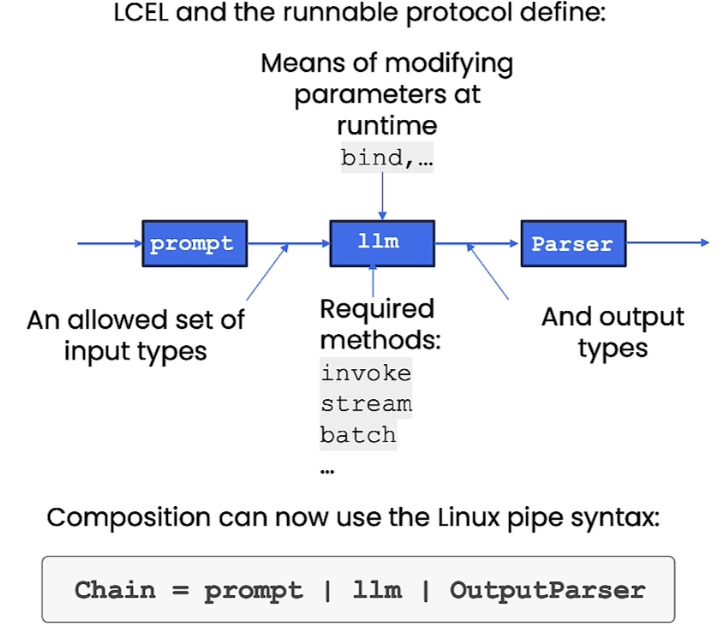

Vsechny runnables by meli obsahovat standardni metody jako je _invoke_ nebo _stream_. Viz obrazek nize:

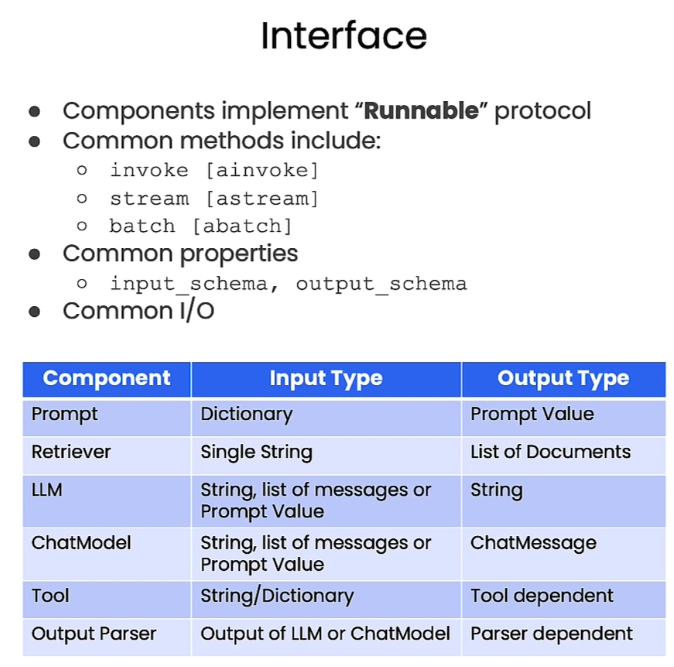

LCEL se pouziva proto, ze zjednodusuje nektery procesy a pridava na efektivite. Jmenovite:
* asynchroni beh jobu
* Fallback, kdyz selze nejaky chain
* Paralellism
* Loggin, ale ten za paywallem

In [ ]:
#!pip install pydantic==1.10.8

Nasledujici import je zakladni kamen LCEL, resp. chainu.
* ChatPromptTemplate - jasny
* ChatOpenAI - jasny
* StrOutputParser - predela odpoved z modelu na string

In [10]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

### Simple Chain

In [11]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [ ]:
chain = prompt | model | output_parser

In [ ]:
chain.invoke({"topic": "bears"})

### More complex chain

And Runnable Map to supply user-provided inputs to the prompt.
Nyni si k tomu jeste pridame RAG, tj. hledani casti dokumentu ze kterych chceme najit odpoved.

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [ ]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [ ]:
retriever.get_relevant_documents("where did harrison work?")

In [ ]:
retriever.get_relevant_documents("what do bears like to eat")

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from langchain.schema.runnable import RunnableMap

In [ ]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [ ]:
chain.invoke({"question": "where did harrison work?"})

In [ ]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [ ]:
inputs.invoke({"question": "where did harrison work?"})

### Bind

an OpenAI Functions

In [ ]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
# normalne bysme zavolali jen ChatOpenAI(), ale protoze chceme pouzit funkce, pridame jeste .bind() metodu
model = ChatOpenAI(temperature=0).bind(functions=functions) 

In [ ]:
runnable = prompt | model

In [ ]:
runnable.invoke({"input": "what is the weather in sf"})

In [ ]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [ ]:
model = model.bind(functions=functions)

In [ ]:
runnable = prompt | model

In [ ]:
runnable.invoke({"input": "how did the patriots do yesterday?"})

### Fallbacks

Tenhle model je starsi a ne moc funkcni. Proto ho pouzijeme jako ten, ktery "selze", abychom mohli demonstrovat fallback na lepsi model. V praxi to nebude "lepsi" model, ale model, ktery bude zachytavat problemy.

In [ ]:
from langchain.llms import OpenAI
import json

**Note**: Due to the deprecation of OpenAI's model `text-davinci-001` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [ ]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="gpt-3.5-turbo-instruct"
)
simple_chain = simple_model | json.loads

In [ ]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [ ]:
simple_model.invoke(challenge)

**Note**: The next line is expected to fail.

In [ ]:
simple_chain.invoke(challenge)

In [ ]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads

In [ ]:
chain.invoke(challenge)

In [ ]:
final_chain = simple_chain.with_fallbacks([chain])

In [ ]:
final_chain.invoke(challenge)

### Interface
Jiny metody nez _invoke_. 

In [ ]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [ ]:
chain.invoke({"topic": "bears"})

In [ ]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

In [ ]:
for t in chain.stream({"topic": "bears"}):
    print(t)

In [ ]:
response = await chain.ainvoke({"topic": "bears"})
response

## Kompletace znalosti z predchozich kapitol

### Pydantic Syntax

Pydantic je velmi podobna standardni Pythonovske knihovne dataclasses, ale pridava na validaci dat = tim se mysli, ze se kontroluje datovy typ, ktery do classy vkladame. Viz priklady nize. 

Dokumentace k Pydantic je [zde](https://docs.pydantic.dev/latest/concepts/models/)

Dokumentace k Python Dataclasses je [zde](https://realpython.com/python-data-classes/)

In [ ]:
class User:
    def __init__(self, name: str, age: int, email: str):
        self.name = name
        self.age = age
        self.email = email

In [ ]:
foo = User(name="Joe",age=32, email="joe@gmail.com")

In [ ]:
foo.name

In [ ]:
foo = User(name="Joe",age="bar", email="joe@gmail.com")

In [ ]:
foo.age

In [ ]:
class pUser(BaseModel):
    name: str
    age: int
    email: str

In [ ]:
foo_p = pUser(name="Jane", age=32, email="jane@gmail.com")

In [ ]:
foo_p.name

**Note**: The next cell is expected to fail.

In [ ]:
foo_p = pUser(name="Jane", age="bar", email="jane@gmail.com")

In [ ]:
class Class(BaseModel):
    students: List[pUser]

In [ ]:
obj = Class(
    students=[pUser(name="Jane", age=32, email="jane@gmail.com")]
)

In [ ]:
obj

### Pydantic to OpenAI function definition


In [ ]:
class WeatherSearch(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str = Field(description="airport code to get weather for")

In [ ]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

In [ ]:
weather_function = convert_pydantic_to_openai_function(WeatherSearch)

In [ ]:
weather_function

In [ ]:
class WeatherSearch1(BaseModel):
    airport_code: str = Field(description="airport code to get weather for")

**Note**: The next cell is expected to generate an error.

In [ ]:
convert_pydantic_to_openai_function(WeatherSearch1)

In [ ]:
class WeatherSearch2(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str

In [ ]:
convert_pydantic_to_openai_function(WeatherSearch2)

In [ ]:
model = ChatOpenAI()

In [ ]:
model.invoke("what is the weather in SF today?", functions=[weather_function])

In [ ]:
model_with_function = model.bind(functions=[weather_function])

In [ ]:
model_with_function.invoke("what is the weather in sf?")

### Forcing it to use a function

We can force the model to use a function

In [ ]:
model_with_forced_function = model.bind(functions=[weather_function], function_call={"name":"WeatherSearch"})

In [ ]:
model_with_forced_function.invoke("what is the weather in sf?")

In [ ]:
model_with_forced_function.invoke("hi!")

### Using in a chain

We can use this model bound to function in a chain as we normally would

In [ ]:
from langchain.prompts import ChatPromptTemplate

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("user", "{input}")
])

In [ ]:
chain = prompt | model_with_function

In [ ]:
chain.invoke({"input": "what is the weather in sf?"})

### Using multiple functions

Even better, we can pass a set of function and let the LLM decide which to use based on the question context.

In [ ]:
class ArtistSearch(BaseModel):
    """Call this to get the names of songs by a particular artist"""
    artist_name: str = Field(description="name of artist to look up")
    n: int = Field(description="number of results")

In [ ]:
functions = [
    convert_pydantic_to_openai_function(WeatherSearch),
    convert_pydantic_to_openai_function(ArtistSearch),
]

In [ ]:
model_with_functions = model.bind(functions=functions)

In [ ]:
model_with_functions.invoke("what is the weather in sf?")

In [ ]:
model_with_functions.invoke("what are three songs by taylor swift?")

In [ ]:
model_with_functions.invoke("hi!")

## Tagging and Extraction Using OpenAI functions

### Tagging

Ackoli jsme si rekli, ze LLM nevola funkce, ktere mu zadame, je tu urcita trida funkci, ktere to dela za nas. Specificky jde o funkce delajici Tagging a Extraction. Tyhle funkce nemusime definovat, staci LLM zadat jen strkturu, jakou chceme, a on je za nas zavola. Neplati to samozrejme o jinych funkcich, napriklad funkce na pocasi, kterou jsme definovali vyse.

In [3]:
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

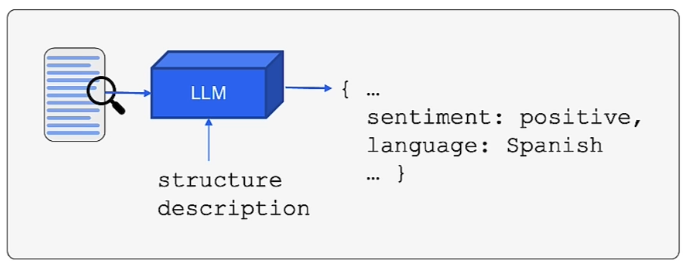

In [ ]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")

In [ ]:
convert_pydantic_to_openai_function(Tagging)

Tak si to ukazeme na celem prikladu:

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [ ]:
model = ChatOpenAI(temperature=0)

In [ ]:
tagging_functions = [convert_pydantic_to_openai_function(Tagging)]

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then tag the text as instructed"),
    ("user", "{input}")
])

Pridame k tomu funkci na Tagging

In [ ]:
model_with_functions = model.bind(
    functions=tagging_functions,
    function_call={"name": "Tagging"}
)

In [ ]:
tagging_chain = prompt | model_with_functions

In [ ]:
tagging_chain.invoke({"input": "I love langchain"})

In [ ]:
tagging_chain.invoke({"input": "non mi piace questo cibo"})

In [ ]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

In [ ]:
tagging_chain = prompt | model_with_functions | JsonOutputFunctionsParser()

In [ ]:
tagging_chain.invoke({"input": "non mi piace questo cibo"})

### Extraction

Extraction is similar to tagging, but used for extracting multiple pieces of information.

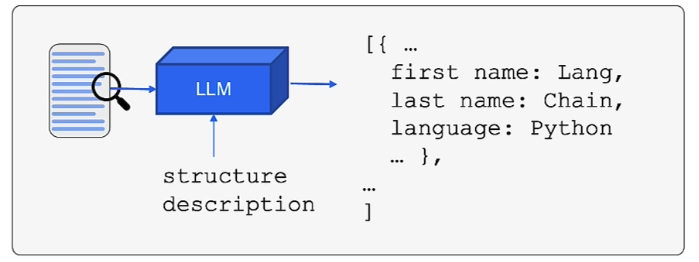

In [ ]:
from typing import Optional
class Person(BaseModel):
    """Information about a person."""
    name: str = Field(description="person's name")
    age: Optional[int] = Field(description="person's age")

In [ ]:
class Information(BaseModel):
    """Information to extract."""
    people: List[Person] = Field(description="List of info about people")

In [ ]:
convert_pydantic_to_openai_function(Information)

In [ ]:
extraction_functions = [convert_pydantic_to_openai_function(Information)]
extraction_model = model.bind(functions=extraction_functions, function_call={"name": "Information"})

In [ ]:
extraction_model.invoke("Joe is 30, his mom is Martha")

Protoze v odpovedi byl vek u Marty uveden jako 0, protoze v textu neni, tak si LLM domyslelo hodnotu. Proti tomu se da bojovat vhodnym promptem.

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the relevant information, if not explicitly provided do not guess. Extract partial info"),
    ("human", "{input}")
])

In [ ]:
extraction_chain = prompt | extraction_model

In [ ]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

In [ ]:
extraction_chain = prompt | extraction_model | JsonOutputFunctionsParser()

In [ ]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

In [ ]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

In [ ]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="people")

In [ ]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

### Doing it for real

We can apply tagging to a larger body of text.

For example, let's load this blog post and extract tag information from a sub-set of the text.

In [ ]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
documents = loader.load()

In [ ]:
doc = documents[0]

In [ ]:
page_content = doc.page_content[:10000]

In [ ]:
print(page_content[:1000])

In [ ]:
class Overview(BaseModel):
    """Overview of a section of text."""
    summary: str = Field(description="Provide a concise summary of the content.")
    language: str = Field(description="Provide the language that the content is written in.")
    keywords: str = Field(description="Provide keywords related to the content.")

In [ ]:
overview_tagging_function = [
    convert_pydantic_to_openai_function(Overview)
]
tagging_model = model.bind(
    functions=overview_tagging_function,
    function_call={"name":"Overview"}
)
tagging_chain = prompt | tagging_model | JsonOutputFunctionsParser()

In [ ]:
tagging_chain.invoke({"input": page_content})

In [ ]:
class Paper(BaseModel):
    """Information about papers mentioned."""
    title: str
    author: Optional[str]


class Info(BaseModel):
    """Information to extract"""
    papers: List[Paper]

In [ ]:
paper_extraction_function = [
    convert_pydantic_to_openai_function(Info)
]
extraction_model = model.bind(
    functions=paper_extraction_function, 
    function_call={"name":"Info"}
)
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [ ]:
extraction_chain.invoke({"input": page_content})

In [ ]:
template = """A article will be passed to you. Extract from it all papers that are mentioned by this article. 

Do not extract the name of the article itself. If no papers are mentioned that's fine - you don't need to extract any! Just return an empty list.

Do not make up or guess ANY extra information. Only extract what exactly is in the text."""

prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", "{input}")
])

In [ ]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [ ]:
extraction_chain.invoke({"input": page_content})

In [ ]:
extraction_chain.invoke({"input": "hi"})

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=0)

In [ ]:
splits = text_splitter.split_text(doc.page_content)

In [ ]:
len(splits)

In [ ]:
def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

In [ ]:
flatten([[1, 2], [3, 4]])

In [ ]:
print(splits[0])

In [ ]:
from langchain.schema.runnable import RunnableLambda

In [ ]:
prep = RunnableLambda(
    lambda x: [{"input": doc} for doc in text_splitter.split_text(x)]
)

In [ ]:
prep.invoke("hi")

A to delame proto, ze chceme vypustit model na list of documents. Proto na vstupu bude list dokumentu, ktere chceme zpracovat, pustime na ne extraction_chain, ale musime pridat metodu .map(), aby se aplikovala na kazdy dokument zvlast. A pomoci funkce flatten() z listu listu udelame list.

In [ ]:
chain = prep | extraction_chain.map() | flatten

In [ ]:
chain.invoke(doc.page_content)

## Tools and Routing

Nektery funkce umi LLM volat samo. Ne vsechny, a in general LLM vraci jen function_call a argumenty, ale uz nevola samotnou funkci. To musi zajistit clovek. Nektery funkce ovsem jsou jiz implementovany v LLM a tak je umi pouzit. 
Mezi takove funkce patri:
* Search Tools
* Math Tools
* SQL Tools
* ...


### Tools

In [ ]:
from langchain.agents import tool

Tool dekorator udela z funkce objekt, ktery danou funkci prevede na langchain callable.

In [ ]:
@tool
def search(query: str) -> str:
    """Search for weather online"""
    return "42f"

In [ ]:
search.name

In [ ]:
search.description

In [ ]:
search.args

Za pouziti pydantic modelu si muzeme pripravit rovnou celou strukturu do jsonu, jako v predchozim pripade.

In [ ]:
from pydantic import BaseModel, Field
class SearchInput(BaseModel):
    query: str = Field(description="Thing to search for")


A tohle schema pak vstupuje do toolu jako argument.

In [ ]:
@tool(args_schema=SearchInput)
def search(query: str) -> str:
    """Search for the weather online."""
    return "42f"

In [ ]:
search.args

A porad je to langchain callable

In [ ]:
search.run("sf")

Udelame si takovy vetsi priklad, ktery bude vracet teplotu v zavislosti na zadane zemepisne delce a sirce.

In [ ]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [ ]:
get_current_temperature.name

In [ ]:
get_current_temperature.description

In [ ]:
get_current_temperature.args

In [ ]:
from langchain.tools.render import format_tool_to_openai_function

In [ ]:
format_tool_to_openai_function(get_current_temperature)

In [ ]:
get_current_temperature({"latitude": 13, "longitude": 14})

A druhy takovy tool bude vyhledavani na Wiki

In [ ]:
import wikipedia
@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [ ]:
search_wikipedia.name

In [ ]:
search_wikipedia.description

In [ ]:
format_tool_to_openai_function(search_wikipedia)

In [ ]:
search_wikipedia({"query": "langchain"})

Casto jsou funkce, ktere chceme pouzivat za nejakym API. Existuje snadna cesta jak takovy api definition prevest na openai spec. V nasledujicim prikladu mame funkci zadanou jako api, vcetne vsech volani. A prevedeme ji na langchain object.

In [ ]:
from langchain.chains.openai_functions.openapi import openapi_spec_to_openai_fn
from langchain.utilities.openapi import OpenAPISpec

In [ ]:
text = """
{
  "openapi": "3.0.0",
  "info": {
    "version": "1.0.0",
    "title": "Swagger Petstore",
    "license": {
      "name": "MIT"
    }
  },
  "servers": [
    {
      "url": "http://petstore.swagger.io/v1"
    }
  ],
  "paths": {
    "/pets": {
      "get": {
        "summary": "List all pets",
        "operationId": "listPets",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "limit",
            "in": "query",
            "description": "How many items to return at one time (max 100)",
            "required": false,
            "schema": {
              "type": "integer",
              "maximum": 100,
              "format": "int32"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "A paged array of pets",
            "headers": {
              "x-next": {
                "description": "A link to the next page of responses",
                "schema": {
                  "type": "string"
                }
              }
            },
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pets"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      },
      "post": {
        "summary": "Create a pet",
        "operationId": "createPets",
        "tags": [
          "pets"
        ],
        "responses": {
          "201": {
            "description": "Null response"
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    },
    "/pets/{petId}": {
      "get": {
        "summary": "Info for a specific pet",
        "operationId": "showPetById",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "petId",
            "in": "path",
            "required": true,
            "description": "The id of the pet to retrieve",
            "schema": {
              "type": "string"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "Expected response to a valid request",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pet"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    }
  },
  "components": {
    "schemas": {
      "Pet": {
        "type": "object",
        "required": [
          "id",
          "name"
        ],
        "properties": {
          "id": {
            "type": "integer",
            "format": "int64"
          },
          "name": {
            "type": "string"
          },
          "tag": {
            "type": "string"
          }
        }
      },
      "Pets": {
        "type": "array",
        "maxItems": 100,
        "items": {
          "$ref": "#/components/schemas/Pet"
        }
      },
      "Error": {
        "type": "object",
        "required": [
          "code",
          "message"
        ],
        "properties": {
          "code": {
            "type": "integer",
            "format": "int32"
          },
          "message": {
            "type": "string"
          }
        }
      }
    }
  }
}
"""

In [ ]:
spec = OpenAPISpec.from_text(text)

In [ ]:
pet_openai_functions, pet_callables = openapi_spec_to_openai_fn(spec)

In [ ]:
pet_openai_functions

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
model = ChatOpenAI(temperature=0).bind(functions=pet_openai_functions)

In [ ]:
model.invoke("what are three pets names")

In [ ]:
model.invoke("tell me about pet with id 42")

### Routing

In lesson 3, we show an example of function calling deciding between two candidate functions.

Given our tools above, let's format these as OpenAI functions and show this same behavior.

Vsimnete si, ze tyto funkce taky LLM nevola, ale vraci _function_call_ a argumenty.

In [ ]:
functions = [
    format_tool_to_openai_function(f) for f in [
        search_wikipedia, get_current_temperature
    ]
]
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [ ]:
model.invoke("what is the weather in sf right now")

In [ ]:
model.invoke("what is langchain")

In [ ]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model

In [ ]:
chain.invoke({"input": "what is the weather in sf right now"})

Tahle langchain callable funkce nam umoznuje rozhodnout, ktera z funkci se ma zavolat a jestli vubec. Abychom nemuseli rucne nacitat, jestli to vraci content='' a tedy jesti to vraci function_call nebo jestli to vraci nejaky content.

In [ ]:
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [ ]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [ ]:
result = chain.invoke({"input": "what is the weather in sf right now"})

In [ ]:
type(result)

In [ ]:
result.tool

In [ ]:
result.tool_input

In [ ]:
get_current_temperature(result.tool_input)

In [ ]:
result = chain.invoke({"input": "hi!"})

In [ ]:
type(result)

In [ ]:
result.return_values

Tady udelame routing: podivame se, jestli type je AgentFinish, tj. nevola zadnou funkci. A pokud neni, najde volanou funkci a zavola ji.

In [ ]:
from langchain.schema.agent import AgentFinish
def route(result):
    if isinstance(result, AgentFinish):
        return result.return_values['output']
    else:
        tools = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }
        return tools[result.tool].run(result.tool_input)

In [ ]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser() | route

In [ ]:
result = chain.invoke({"input": "What is the weather in san francisco right now?"})

In [ ]:
result

In [ ]:
result = chain.invoke({"input": "What is langchain?"})

In [ ]:
result

In [ ]:
chain.invoke({"input": "hi!"})

## Conversational agent

Ted to dame vsechno dohromady. Zkombinuje tools a chat memory.

Opáčko:
* agents: 
  * kombinace llm a code
  * llm rozhodne, jakou cast kodu zavolat
* agent loop:
  * rozhodne, ktery tool zavolat
  * sleduje vysledek volani toolu
  * opakuje, dokud neni splneno stopping criterea
* Stopping condition muze byt:
  * llm se rozhodne, ze staci
  * hard-coded

V tehle casti:
* si pripravime nekolik toolu
* napiseme agenta s pomoci LCEL
* pouzijeme agent_executor, ktery
  * vytvori agent loop
  * prida overhead jako jsou logy, error handling, early stopping, tracing, ....

In [ ]:
from langchain.tools import tool

Tady si vytvorime jiz znamou funkci na hledani teploty na zaklade polohy.

In [ ]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

Tady si vytvorime jiz znamy tool na hledani wikipedie

In [ ]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [ ]:
tools = [get_current_temperature, search_wikipedia]

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

Vytvorime si klasicky chain, ktery zname uz z predchozi kapitoly.

In [ ]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [ ]:
result = chain.invoke({"input": "what is the weather is sf?"})

In [ ]:
result.tool

In [ ]:
result.tool_input

Abychom mohli do LLM zaznamenavat vysledek volani toolu, musime pridat novou promennou "agent_scratchpad". Tato promenna je _MessagesPlaceholder_.

In [ ]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [ ]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

Tady zavolame chain a do _agent_scratchpad_ vkladame prazdny list.

In [ ]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})

In [ ]:
result1.tool

In [ ]:
observation = get_current_temperature(result1.tool_input)

In [ ]:
observation

In [ ]:
type(result1)

In [ ]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [ ]:
result1.message_log

Pomoci funkce _format_to_openai_functions()_ si ulozime vysledek, resp. tuple volani a vysledek, do promenne _agent_scratchpad_.

In [ ]:
format_to_openai_functions([(result1, observation), ])

In [ ]:
result2 = chain.invoke({
    "input": "what is the weather is sf?", 
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [ ]:
result2

Ted to cele zabalime do agent loopu, ktery se bude volat tak dlouho dokud nenarazi na _AgentFinish_ type, ktery znamena, ze uz neni treba volat zadnou dalsi funkci.

In [ ]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input, 
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

Funkce _RunnablePassthrough_ vytvori dictionary, ktery umi langchain pouzivat. Takze abychom nemeli neznamou funkci v nasem _run_agent_, tak budeme mit chain, do kteryho vstupuje dictionary tvoreny promennoou _agent_scratchpad_ a ten se preda chain.

In [ ]:
from langchain.schema.runnable import RunnablePassthrough
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [ ]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input, 
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [ ]:
run_agent("what is the weather is sf?")

In [ ]:
run_agent("what is langchain?")

In [ ]:
run_agent("hi!")

A celou tuhle funkci umime zabalit do funkce _AgentExecutor_, ktera dela presne to, co je nahore, plus pridava nekolik dalsich veci, jako je lepsi error handling, error handling toolu, logging, early stopping, tracing, ....

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [ ]:
agent_executor.invoke({"input": "what is langchain?"})

In [ ]:
agent_executor.invoke({"input": "my name is bob"})

In [ ]:
agent_executor.invoke({"input": "what is my name"})

Nicmene, tenhle chain nema pamet. Abychom mohli udrzovat konverzaci, musime pridat pamet. Tedy _ChatMemory_.

Musime pridat novou promennou _chat_memory_, ktera bude obsahovat chatovaci historii. Opet pouzijeme _MessagesPlaceholder_.

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [ ]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

In [ ]:
agent_executor = AgentExecutor(
    agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [ ]:
agent_executor.invoke({"input": "my name is bob"})

In [ ]:
agent_executor.invoke({"input": "whats my name"})

In [ ]:
agent_executor.invoke({"input": "whats the weather in sf?"})

### Create a chatbot

Zaverecni priklad s dashboardem a chatbotem.

In [ ]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [ ]:
tools = [get_current_temperature, search_wikipedia, create_your_own]

In [ ]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):
    
    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)
    
    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return 

In [ ]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp) 

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)
dashboard